In [1]:
%matplotlib inline

import math
import datetime

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

debug = True

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# import pip 

cuda = True

# the code below seems broken with newer versions of pip...
# l = next(str(i) for i in pip.get_installed_distributions() if 'tensorflow' in str(i))
# if l.startswith('tensorflow-gpu'):
#     cuda = True

In [3]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

colormap = plt.get_cmap('rainbow')

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [4]:
N = 25 #Number of experiments
 
def encode(msg):
    encoded = [0]*8
    for x in msg:
        if x.startswith('m1'):
            encoded[0] = 1.0
        elif x.startswith('m2'):
            encoded[1] = 1.0
        elif x.startswith('m3'):
            encoded[2] = 1.0
        elif x == 'a':
            encoded[3] = 1.0
        elif x == 'b':
            encoded[4] = 1.0
        elif x == 'c':
            encoded[5] = 1.0  
        elif x == 'd':
            encoded[6] = 1.0   
        elif x == 'e':
            encoded[7] = 1.0
    return encoded

def decode(encoded):
    message = []
    if (encoded[0] > encoded[1] and encoded[0] > encoded[2]):
        message.append('m1')
    elif (encoded[1] > encoded[0] and encoded[1] > encoded[2]):
        message.append('m2')
    elif (encoded[2] > encoded[0] and encoded[2] > encoded[1]):
        message.append('m3')
    else:
        message.append('m?')
        
    if (encoded[3] >= 0.5):
        message.append('a')
    if (encoded[4] >= 0.5):
        message.append('b')
    if (encoded[5] >= 0.5):
        message.append('c')
    if (encoded[6] >= 0.5):
        message.append('d')
    if (encoded[7] >= 0.5):
        message.append('e')        
        
    return message
        

def logToData(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break        
        if line.startswith('!'):
            raw_bytes = list(line[1:].strip().split(',')[:-1])
            raw_bytes_float = []
            for b in raw_bytes:
                raw_bytes_float.append(int(b)/255)
            while True:
                line = file.readline()      
                if not line:
                    break        
                elif line.startswith('@'):
                    encoded = encode(line.split('@')[2].split(','))
                    yield raw_bytes_float, encoded
                    break;    

In [5]:
def loadAllData(base, N):
    maxbytelen = 0
    logs = []
    for i in range(0,N):
        log = list(logToData(base+str(i)+'.log'))
        logs.append(log)
        for msg in log:
            length = len(msg[0])
            maxbytelen = max(maxbytelen, length)
    X = []
    Y = []
    for log in logs:
        x = np.zeros((len(log),maxbytelen))
        y = np.zeros((len(log),8))
        for i, msg in enumerate(log):
            x[i,0:len(msg[0])] = msg[0]
            y[i,:] = msg[1]
        X.append(x)
        Y.append(y)
    return X, Y, maxbytelen

In [6]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'

base_X, base_Y, base_maxbytelen = loadAllData(base_dir+'base/nodejs', N)
static_X, static_Y, static_maxbytelen = loadAllData(base_dir+'static/nodejs', N)
runtime_X, runtime_Y, runtime_maxbytelen = loadAllData(base_dir+'dynamic/nodejs', N)

In [7]:
def split(data, train_ratio = 0.67):
    train = []
    test = []
    for log in data:
        length = log.shape[0]
        train_size = int(length * train_ratio)
        train.append(log[0:train_size,:])
        test.append(log[train_size:,:])
    return train, test

base_X_train, base_X_test = split(base_X)
base_Y_train, base_Y_test = split(base_Y)
static_X_train, static_X_test = split(static_X)
static_Y_train, static_Y_test = split(static_Y)
runtime_X_train, runtime_X_test = split(runtime_X)
runtime_Y_train, runtime_Y_test = split(runtime_Y)

In [8]:
number_of_interactions = 6 
size_of_interactions = 3

def series_to_supervised(all_data, maxbytelen):
    results = []
    for j in range(0,N):
        result = []
        data = all_data[j].flatten()
        for i in range(0,int(len(data)/(number_of_interactions*size_of_interactions*maxbytelen))):
            time_window = data[i*maxbytelen:number_of_interactions*size_of_interactions*maxbytelen+i*maxbytelen]
            result.append(time_window)
        results.append(result)
    np_results = np.array(results)
    n = number_of_interactions*size_of_interactions
    np_results = np.reshape(np_results, (np_results.shape[0], np_results.shape[1], n, int(np_results.shape[2]/n)))
    return np_results

base_X_train_supervised = series_to_supervised(base_X_train, base_maxbytelen)
static_X_train_supervised = series_to_supervised(static_X_train, static_maxbytelen)
runtime_X_train_supervised = series_to_supervised(runtime_X_train, runtime_maxbytelen)

base_Y_train_supervised = series_to_supervised(base_Y_train, 8)
static_Y_train_supervised = series_to_supervised(static_Y_train, 8)
runtime_Y_train_supervised = series_to_supervised(runtime_Y_train, 8)

base_X_test_supervised = series_to_supervised(base_X_test, base_maxbytelen)
static_X_test_supervised = series_to_supervised(static_X_test, static_maxbytelen)
runtime_X_test_supervised = series_to_supervised(runtime_X_test, runtime_maxbytelen)

base_Y_test_supervised = series_to_supervised(base_Y_test, 8)
static_Y_test_supervised = series_to_supervised(static_Y_test, 8)
runtime_Y_test_supervised = series_to_supervised(runtime_Y_test, 8)

if debug:
    print(base_X_train_supervised.shape, ' ', base_Y_train_supervised.shape)
    print(static_X_train_supervised.shape, ' ', static_Y_train_supervised.shape)
    print(runtime_X_train_supervised.shape, ' ', runtime_Y_train_supervised.shape)

    print(base_X_test_supervised.shape, ' ', base_Y_test_supervised.shape)
    print(static_X_test_supervised.shape, ' ', static_Y_test_supervised.shape)
    print(runtime_X_test_supervised.shape, ' ', runtime_Y_test_supervised.shape)

(25, 55, 18, 7)   (25, 55, 18, 8)
(25, 111, 18, 22)   (25, 111, 18, 8)
(25, 111, 18, 13)   (25, 111, 18, 8)
(25, 27, 18, 7)   (25, 27, 18, 8)
(25, 55, 18, 22)   (25, 55, 18, 8)
(25, 55, 18, 13)   (25, 55, 18, 8)


In [9]:
def keras_model(x, y):    
    model = keras.Sequential()
    #model.add(keras.layers.Dropout(0.2, input_shape=(x,)))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(250, activation='relu', input_dim=x)))
    if cuda:
        model.add(keras.layers.CuDNNLSTM(125, return_sequences=True))
    else:
        model.add(keras.layers.LSTM(125, return_sequences=True))
    #model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(50, activation='relu')))
    #model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(y, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_accuracy'])    
    return model

def train_and_save(model, train_X, train_Y, test_X, test_Y, mode, xp, save=False):        
    earlystop_loss = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.000025, patience=25, verbose=1, mode='min')
    earlystop_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.000025, patience=25, verbose=1, mode='min')
    earlystop_acc = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.000025, patience=25, verbose=1, mode='max')
    earlystop_val_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.000025, patience=25, verbose=1, mode='max')
    
    tensorboard_log = keras.callbacks.TensorBoard(log_dir=base_dir+'/tensorboard/'+mode+'/'+str(xp))
    
    callbacks_list = [tensorboard_log, earlystop_loss, earlystop_val_loss, earlystop_acc, earlystop_val_acc]  
        
    model.fit(train_X, train_Y, batch_size=1, epochs=100, validation_split=0.1, verbose=1, callbacks=callbacks_list)

    if save:
        model.save(base_dir + mode + str(xp) + '_class_lstm.h5')
#         try:
#             keras.utils.plot_model(model, to_file=base_dir + mode + str(xp) + '_class_lstm.png')
#         except:
#             print('Cound not save image for Keras model at ', to_file=base_dir + mode + str(xp)+'_class_lstm.png')
            
#     if debug:
#         result = model.evaluate(test_X, test_Y)
#         print(result)
    return model

In [10]:
def predict(model, test_X, test_Y):

    predictions = model.predict(test_X)

    errors = 0
    for i in range(0, predictions.shape[0]):
        for j in range(0, predictions.shape[2], 8):
            predicted = encode(decode(predictions[i][0][j:j+8]))
            truth = test_Y[i][0][j:j+8]
            errs = np.sum(np.abs(predicted - truth))/len(truth)
            if errs > 0:
                errors = errors + errs
                print('Predicting ', decode(predicted), '. Truth is ', decode(truth))    
    error_ratio = round((errors/(test_Y.shape[0]*test_Y.shape[2])*100),2)

    return error_ratio

In [11]:
def xp(train_X, train_Y, test_X, test_Y, mode):
    print('xp ', mode)
    results = []
    for i in range(0, N): 
        print('  #', i)
        print('----')
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X[i], train_Y[i], test_X[i], test_Y[i], mode, i, save=True)
        model.summary()
        train_stop = predict_start = datetime.datetime.now()
        error_ratio = predict(model, test_X[i], test_Y[i])
        predict_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        predict_duration = predict_stop - predict_start
        print(error_ratio, '% error')
        print('training duration = ', train_duration)
        print('prediction duration = ', predict_duration)
        results.append((error_ratio, train_duration, predict_duration))
    return results

In [12]:
base_results = xp(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results = xp(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results = xp(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')

xp  base
  # 0
----
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 2s 37ms/step - loss: 0.5931 - acc: 0.6978 - binary_accuracy: 0.6978 - val_loss: 0.5602 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.5498 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5224 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 9ms/step - loss: 0.2659 - acc: 0.8828 - binary_accuracy: 0.8828 - val_loss: 0.0460 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 4/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0326 - acc: 0.9885 - binary_accuracy: 0.9885 - val_loss: 0.0221 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 5/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0208 - acc: 0.9885 - binary_accuracy: 0.9885 - val_loss: 0.0174 - val_acc: 0.9861 - val_binary_accuracy: 0.9861


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 250)           2000      
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 50)            6300      
_________________________________________________________________
dense_2 (Dense)              (None, 18, 8)             408       
Total params: 197,208
Trainable params: 197,208
Non-trainable params: 0
_________________________________________________________________
0.0 % error
training duration =  0:00:26.713660
prediction duration =  0:00:00.172025
  # 1
----
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 22ms/step - loss: 0.6014 - acc: 0.7029 - binary_accuracy: 0.7029 - val_l

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 18, 250)           2000      
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 50)            6300      
_________________________________________________________________
dense_5 (Dense)              (None, 18, 8)             408       
Total params: 197,208
Trainable params: 197,208
Non-trainable params: 0
_________________________________________________________________
0.0 % error
training duration =  0:00:20.330519
prediction duration =  0:00:00.144000
  # 2
----
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 27ms/step - loss: 0.6008 - acc: 0.6755 - binary_accuracy: 0.6755 - val_l

49/49 [==============================] - 0s 9ms/step - loss: 0.0011 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.9145e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 40/100
49/49 [==============================] - 0s 9ms/step - loss: 0.0011 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.2702e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 41/100
49/49 [==============================] - 0s 9ms/step - loss: 8.2095e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 42/100
49/49 [==============================] - 0s 9ms/step - loss: 8.0883e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.7376e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 43/100
49/49 [==============================] - 0s 9ms/step - loss: 8.2400e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1566e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 44/100
49/49 [=========================

Epoch 29/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0023 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0015 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0014 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0018 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0022 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0016 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 33/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0015 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.3453e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 34/100
49/49 [==============================] - 0s

Epoch 24/100
49/49 [==============================] - 0s 7ms/step - loss: 0.0073 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0039 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0059 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0048 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 27/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0047 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0024 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 28/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0065 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0031 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 29/100
49/49 [==============================] - 0s 8ms

Epoch 19/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0092 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0125 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 20/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0103 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0084 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 21/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0107 - acc: 0.9946 - binary_accuracy: 0.9946 - val_loss: 0.0104 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 22/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0120 - acc: 0.9916 - binary_accuracy: 0.9916 - val_loss: 0.0098 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 23/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0089 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0099 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 24/100
49/49 [==============================] - 0s 8ms

Epoch 8/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0148 - acc: 0.9908 - binary_accuracy: 0.9908 - val_loss: 0.0156 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 9/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0139 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0139 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0129 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0133 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 11/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0114 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0166 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 12/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0134 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0119 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 13/100
49/49 [==============================] - 0s 8ms/s

0.0 % error
training duration =  0:00:22.368909
prediction duration =  0:00:00.283754
  # 7
----
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 20ms/step - loss: 0.5805 - acc: 0.6993 - binary_accuracy: 0.6993 - val_loss: 0.5542 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 8ms/step - loss: 0.5233 - acc: 0.7163 - binary_accuracy: 0.7163 - val_loss: 0.4255 - val_acc: 0.8079 - val_binary_accuracy: 0.8079
Epoch 3/100
49/49 [==============================] - 0s 8ms/step - loss: 0.1138 - acc: 0.9668 - binary_accuracy: 0.9668 - val_loss: 0.0253 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0208 - acc: 0.9898 - binary_accuracy: 0.9898 - val_loss: 0.0175 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0169 - acc: 0.9922 - binary_accuracy

Epoch 1/100
49/49 [==============================] - 1s 20ms/step - loss: 0.5885 - acc: 0.7054 - binary_accuracy: 0.7054 - val_loss: 0.5601 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 8ms/step - loss: 0.5452 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5025 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 8ms/step - loss: 0.2001 - acc: 0.9194 - binary_accuracy: 0.9194 - val_loss: 0.0392 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0246 - acc: 0.9901 - binary_accuracy: 0.9901 - val_loss: 0.0244 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0208 - acc: 0.9892 - binary_accuracy: 0.9892 - val_loss: 0.0178 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 6/100
49/49 [==============================] - 0s 8ms/step

0.0 % error
training duration =  0:00:21.120024
prediction duration =  0:00:00.334871
  # 9
----
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 20ms/step - loss: 0.5919 - acc: 0.6790 - binary_accuracy: 0.6790 - val_loss: 0.5580 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 8ms/step - loss: 0.5494 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5223 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 0s 8ms/step - loss: 0.2684 - acc: 0.8766 - binary_accuracy: 0.8766 - val_loss: 0.0458 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0312 - acc: 0.9892 - binary_accuracy: 0.9892 - val_loss: 0.0213 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0213 - acc: 0.9895 - binary_accuracy

0.0 % error
training duration =  0:00:20.124594
prediction duration =  0:00:00.378039
  # 10
----
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 20ms/step - loss: 0.6009 - acc: 0.7011 - binary_accuracy: 0.7011 - val_loss: 0.5538 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 0s 8ms/step - loss: 0.4518 - acc: 0.7714 - binary_accuracy: 0.7714 - val_loss: 0.1307 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 3/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0429 - acc: 0.9875 - binary_accuracy: 0.9875 - val_loss: 0.0233 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0178 - acc: 0.9925 - binary_accuracy: 0.9925 - val_loss: 0.0236 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0139 - acc: 0.9938 - binary_accurac

49/49 [==============================] - 0s 8ms/step - loss: 0.5373 - acc: 0.7086 - binary_accuracy: 0.7086 - val_loss: 0.4716 - val_acc: 0.7315 - val_binary_accuracy: 0.7315
Epoch 3/100
49/49 [==============================] - 0s 8ms/step - loss: 0.1703 - acc: 0.9365 - binary_accuracy: 0.9365 - val_loss: 0.0323 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0252 - acc: 0.9899 - binary_accuracy: 0.9899 - val_loss: 0.0188 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 5/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0180 - acc: 0.9904 - binary_accuracy: 0.9904 - val_loss: 0.0159 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0166 - acc: 0.9918 - binary_accuracy: 0.9918 - val_loss: 0.0142 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 7/100
49/49 [==============================] - 0s 8ms/step - loss: 0.01

49/49 [==============================] - 0s 8ms/step - loss: 8.3413e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.1360e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 46/100
49/49 [==============================] - 0s 8ms/step - loss: 4.2466e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.2502e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 47/100
49/49 [==============================] - 0s 8ms/step - loss: 3.7139e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.4239e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 48/100
49/49 [==============================] - 0s 8ms/step - loss: 3.6371e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.7527e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00048: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_22 (TimeDis (None, 18, 250)           2000      
___

Epoch 35/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0017 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 9.4178e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 36/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0021 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0016 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 37/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0015 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 8.7289e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 38/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0012 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1554e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 39/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0010 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.4907e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 40/100
49/49 [========================

Epoch 33/100
49/49 [==============================] - 0s 8ms/step - loss: 5.8044e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.8448e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 34/100
49/49 [==============================] - 0s 8ms/step - loss: 4.2181e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.4292e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 35/100
49/49 [==============================] - 0s 8ms/step - loss: 6.5813e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1536e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 36/100
49/49 [==============================] - 0s 8ms/step - loss: 3.2804e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.5915e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00036: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 18, 250)           2

Epoch 35/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0016 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 36/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0017 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 37/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0012 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0015 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 38/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0014 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 9.8933e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 39/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0012 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0018 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 40/100
49/49 [==============================] - 0s

49/49 [==============================] - 0s 8ms/step - loss: 0.0016 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0018 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0019 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0033 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 9.1932e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 33/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0017 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 7.7004e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 34/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0015 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 35/100
49/49 [==============================] - 0s 8ms/step

49/49 [==============================] - 0s 8ms/step - loss: 0.0028 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 7.0717e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0020 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.2638e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0027 - acc: 0.9991 - binary_accuracy: 0.9991 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0016 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.6536e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 33/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0020 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 5.3900e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 34/100
49/49 [==============================] - 0s 

Epoch 26/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0031 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0059 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 27/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0034 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0029 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 28/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0029 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0025 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 29/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0041 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0137 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 30/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0083 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0052 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 31/100
49/49 [==============================] - 0s 8ms

49/49 [==============================] - 0s 9ms/step - loss: 0.0060 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0072 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 21/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0063 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0053 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0052 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0053 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0046 - acc: 0.9991 - binary_accuracy: 0.9991 - val_loss: 0.0046 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 24/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0033 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0175 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 25/100
49/49 [==============================] - 0s 8ms/step - loss:

49/49 [==============================] - 0s 8ms/step - loss: 0.0133 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0118 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 13/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0124 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0121 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 14/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0122 - acc: 0.9936 - binary_accuracy: 0.9936 - val_loss: 0.0101 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 15/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0123 - acc: 0.9932 - binary_accuracy: 0.9932 - val_loss: 0.0100 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 16/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0110 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0087 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 17/100
49/49 [==============================] - 0s 8ms/step - loss:

49/49 [==============================] - 0s 8ms/step - loss: 0.0138 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0117 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0127 - acc: 0.9922 - binary_accuracy: 0.9922 - val_loss: 0.0125 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 11/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0122 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0100 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 12/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0116 - acc: 0.9932 - binary_accuracy: 0.9932 - val_loss: 0.0097 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 13/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0105 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0082 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 14/100
49/49 [==============================] - 0s 8ms/step - loss:

49/49 [==============================] - 0s 8ms/step - loss: 0.0217 - acc: 0.9888 - binary_accuracy: 0.9888 - val_loss: 0.0184 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 6/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0178 - acc: 0.9892 - binary_accuracy: 0.9892 - val_loss: 0.0162 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 7/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0159 - acc: 0.9887 - binary_accuracy: 0.9887 - val_loss: 0.0153 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 8/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0165 - acc: 0.9891 - binary_accuracy: 0.9891 - val_loss: 0.0146 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 9/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0148 - acc: 0.9902 - binary_accuracy: 0.9902 - val_loss: 0.0140 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 10/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0

49/49 [==============================] - 0s 8ms/step - loss: 4.7148e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.9846e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 49/100
49/49 [==============================] - 0s 8ms/step - loss: 4.3155e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.7150e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 50/100
49/49 [==============================] - 0s 8ms/step - loss: 4.4847e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.7335e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00050: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_42 (TimeDis (None, 18, 250)           2000      
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 18, 125)           188500    
_________________________________________________________________
t

49/49 [==============================] - 0s 8ms/step - loss: 0.0059 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 7.2289e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 37/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0054 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0016 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 38/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0044 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 8.2713e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 39/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0020 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 6.9242e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00039: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_44 (TimeDis (None, 18, 250)           2000      
_______________________

Epoch 35/100
49/49 [==============================] - 0s 8ms/step - loss: 5.6542e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.4369e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00035: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_46 (TimeDis (None, 18, 250)           2000      
_________________________________________________________________
cu_dnnlstm_23 (CuDNNLSTM)    (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_47 (TimeDis (None, 18, 50)            6300      
_________________________________________________________________
dense_71 (Dense)             (None, 18, 8)             408       
Total params: 197,208
Trainable params: 197,208
Non-trainable params: 0
_________________________________________________________________
0.0 % error
training duration =  0:00:23.028

49/49 [==============================] - 0s 8ms/step - loss: 0.0013 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0033 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 39/100
49/49 [==============================] - 0s 8ms/step - loss: 0.0014 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0028 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 40/100
49/49 [==============================] - 0s 8ms/step - loss: 8.7144e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0069 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 41/100
49/49 [==============================] - 0s 8ms/step - loss: 8.6492e-04 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0055 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 42/100
49/49 [==============================] - 0s 8ms/step - loss: 7.2952e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0078 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 43/100
49/49 [==============================] - 0s 8ms/

Epoch 32/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0085 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0142 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 33/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0078 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0103 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 34/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0079 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0122 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 35/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0119 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0145 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 36/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0081 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0100 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 37/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 8ms/step - loss: 8.2472e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 76/100
99/99 [==============================] - 1s 8ms/step - loss: 9.5799e-04 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0024 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 77/100
99/99 [==============================] - 1s 8ms/step - loss: 6.8622e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0034 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 78/100
99/99 [==============================] - 1s 8ms/step - loss: 8.7919e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0018 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 79/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0016 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0029 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 80/100
99/99 [==============================] - 1s 

99/99 [==============================] - 1s 8ms/step - loss: 0.0032 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0022 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0031 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0028 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0027 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0025 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 0.0025 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 33/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0022 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0022 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 34/100
99/99 [==============================] - 1s 8ms/step - loss:

Epoch 20/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0157 - acc: 0.9913 - binary_accuracy: 0.9913 - val_loss: 0.0114 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 21/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0141 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0125 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 22/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0138 - acc: 0.9922 - binary_accuracy: 0.9922 - val_loss: 0.0153 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 23/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0135 - acc: 0.9929 - binary_accuracy: 0.9929 - val_loss: 0.0148 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 24/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0170 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.0114 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 25/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0071 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 64/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0099 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0073 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 65/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0087 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0120 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 66/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0104 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0065 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 67/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0088 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0061 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 68/100
99/99 [==============================] - 1s 8ms/step - loss:

Epoch 15/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0070 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0069 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 16/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0071 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0067 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 17/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0074 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0069 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 18/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0068 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0071 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 19/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0069 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0069 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 20/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 23/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0091 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 24/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0092 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 25/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 26/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 27/100
99/99 [==============================] - 1s 8ms/step - loss:

Epoch 29/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0091 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0149 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 30/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0085 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0159 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 31/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0095 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0106 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 32/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0089 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0155 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 33/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0089 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0174 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 34/100
99/99 [==============================] - 1s 8ms

Epoch 10/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0106 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0099 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 11/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0096 - acc: 0.9950 - binary_accuracy: 0.9950 - val_loss: 0.0105 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 12/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0091 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0176 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 13/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0124 - acc: 0.9929 - binary_accuracy: 0.9929 - val_loss: 0.0079 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 14/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0093 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0080 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 15/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 8ms/step - loss: 0.0074 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0069 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 11/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0079 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.0107 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 12/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0066 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0057 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 13/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0069 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0057 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 14/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0060 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0047 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 15/100
99/99 [==============================] - 1s 8ms/step - loss:

99/99 [==============================] - 1s 8ms/step - loss: 0.0128 - acc: 0.9925 - binary_accuracy: 0.9925 - val_loss: 0.0137 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 10/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0138 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0121 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 11/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0126 - acc: 0.9909 - binary_accuracy: 0.9909 - val_loss: 0.0119 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 12/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0122 - acc: 0.9930 - binary_accuracy: 0.9930 - val_loss: 0.0129 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 13/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0127 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0131 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 14/100
99/99 [==============================] - 1s 8ms/step - los

99/99 [==============================] - 1s 8ms/step - loss: 0.0265 - acc: 0.9877 - binary_accuracy: 0.9877 - val_loss: 0.0231 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 7/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0238 - acc: 0.9890 - binary_accuracy: 0.9890 - val_loss: 0.0196 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 8/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0184 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0160 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 9/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0161 - acc: 0.9915 - binary_accuracy: 0.9915 - val_loss: 0.0148 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 10/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0149 - acc: 0.9916 - binary_accuracy: 0.9916 - val_loss: 0.0143 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 11/100
99/99 [==============================] - 1s 8ms/step - loss: 0.

99/99 [==============================] - 1s 8ms/step - loss: 0.0084 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0051 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 50/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0060 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0050 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 51/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0060 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0050 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 52/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0066 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0118 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 00052: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_68 (TimeDis (None, 18, 250)           5750      
___________________________________

99/99 [==============================] - 1s 8ms/step - loss: 0.0090 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0064 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 31/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0088 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0061 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 32/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0088 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0060 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 33/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0085 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0057 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 34/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0081 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0076 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 35/100
99/99 [==============================] - 1s 10ms/step - los

Epoch 74/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0023 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0011 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 75/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0020 - acc: 0.9995 - binary_accuracy: 0.9995 - val_loss: 0.0011 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 76/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0019 - acc: 0.9995 - binary_accuracy: 0.9995 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 77/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0021 - acc: 0.9995 - binary_accuracy: 0.9995 - val_loss: 0.0020 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 78/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0152 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0010 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 79/100
99/99 [==============================] - 1s 8ms

Epoch 24/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0060 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0071 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 25/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0060 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0047 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 26/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0060 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0108 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 27/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0075 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0043 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 28/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0054 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0044 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 29/100
99/99 [==============================] - 1s 8ms

Epoch 25/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0105 - acc: 0.9946 - binary_accuracy: 0.9946 - val_loss: 0.0102 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 26/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0108 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0090 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 27/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0107 - acc: 0.9946 - binary_accuracy: 0.9946 - val_loss: 0.0087 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 28/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0097 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0091 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 29/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0101 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0082 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 30/100
99/99 [==============================] - 1s 8ms

Epoch 7/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0169 - acc: 0.9922 - binary_accuracy: 0.9922 - val_loss: 0.0159 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 8/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0161 - acc: 0.9928 - binary_accuracy: 0.9928 - val_loss: 0.0154 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 9/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0152 - acc: 0.9927 - binary_accuracy: 0.9927 - val_loss: 0.0142 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 10/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0142 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.0129 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 11/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0141 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0129 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 12/100
99/99 [==============================] - 1s 10ms/s

99/99 [==============================] - 1s 9ms/step - loss: 0.0247 - acc: 0.9879 - binary_accuracy: 0.9879 - val_loss: 0.0229 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 4/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0228 - acc: 0.9875 - binary_accuracy: 0.9875 - val_loss: 0.0215 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 5/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0211 - acc: 0.9894 - binary_accuracy: 0.9894 - val_loss: 0.0212 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 6/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0210 - acc: 0.9879 - binary_accuracy: 0.9879 - val_loss: 0.0202 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 7/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0220 - acc: 0.9872 - binary_accuracy: 0.9872 - val_loss: 0.0195 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 8/100
99/99 [==============================] - 1s 9ms/step - loss: 0.01

Epoch 47/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0082 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0074 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 48/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0079 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0072 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 49/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0078 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0073 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 50/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0072 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0073 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 51/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0079 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0075 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 52/100
99/99 [==============================] - 1s 9ms

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 2s 22ms/step - loss: 0.4972 - acc: 0.7639 - binary_accuracy: 0.7639 - val_loss: 0.1022 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 2/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0551 - acc: 0.9750 - binary_accuracy: 0.9750 - val_loss: 0.0371 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 3/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0381 - acc: 0.9813 - binary_accuracy: 0.9813 - val_loss: 0.0280 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 4/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0268 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0197 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 5/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0199 - acc: 0.9924 - binary_accuracy: 0.9924 - val_loss: 0.0156 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 6/100
99/99 [=

Epoch 5/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0250 - acc: 0.9857 - binary_accuracy: 0.9857 - val_loss: 0.0262 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 6/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0263 - acc: 0.9853 - binary_accuracy: 0.9853 - val_loss: 0.0228 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 7/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0237 - acc: 0.9855 - binary_accuracy: 0.9855 - val_loss: 0.0224 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 8/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0219 - acc: 0.9874 - binary_accuracy: 0.9874 - val_loss: 0.0197 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 9/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0242 - acc: 0.9865 - binary_accuracy: 0.9865 - val_loss: 0.0192 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 10/100
99/99 [==============================] - 1s 11ms/st

Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
0.62 % error
training duration =  0:00:54.865787
prediction duration =  0:00:01.622629
  # 17
----
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 2s 20ms/step - loss: 0.3869 - acc: 0.8165 - binary_accuracy: 0.8165 - val_loss: 0.0493 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 2/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0278 - acc: 0.9884 - binary_accuracy: 0.9884 - val_loss: 0.0204 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Ep

99/99 [==============================] - 1s 9ms/step - loss: 0.0072 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0054 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 00041: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_84 (TimeDis (None, 18, 250)           5750      
_________________________________________________________________
cu_dnnlstm_42 (CuDNNLSTM)    (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_85 (TimeDis (None, 18, 50)            6300      
_________________________________________________________________
dense_128 (Dense)            (None, 18, 8)             408       
Total params: 200,958
Trainable params: 200,958
Non-trainable params: 0
_________________________________________________________________
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'

Epoch 35/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0034 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 36/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0034 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 37/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0035 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 38/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0034 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 39/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0033 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 40/100
99/99 [==============================] - 1s 8ms

99/99 [==============================] - 1s 9ms/step - loss: 0.0052 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0049 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 00029: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_88 (TimeDis (None, 18, 250)           5750      
_________________________________________________________________
cu_dnnlstm_44 (CuDNNLSTM)    (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_89 (TimeDis (None, 18, 50)            6300      
_________________________________________________________________
dense_134 (Dense)            (None, 18, 8)             408       
Total params: 200,958
Trainable params: 200,958
Non-trainable params: 0
_________________________________________________________________
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . T

99/99 [==============================] - 1s 9ms/step - loss: 0.0042 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0037 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 37/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0042 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0039 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 38/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0043 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0083 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 39/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0041 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 40/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0038 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0035 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 41/100
99/99 [==============================] - 1s 9ms/step - los

Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
1.36 % error
training duration =  0:00:40.488979
prediction duration =  0:00:01.699550
  # 22
----
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 2s 22ms/step - loss: 0.3992 - ac

Epoch 40/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0052 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0049 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 41/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0051 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0048 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 42/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0052 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0048 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 43/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0051 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0048 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 44/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0051 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0049 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 45/100
99/99 [==============================] - 1s 9ms

99/99 [==============================] - 1s 8ms/step - loss: 0.0105 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0174 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 26/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0108 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0135 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 27/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0096 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0145 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 28/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0094 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0151 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 29/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0091 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0152 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 30/100
99/99 [==============================] - 1s 8ms/step - lo

99/99 [==============================] - 1s 8ms/step - loss: 0.0067 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0074 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 69/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0072 - acc: 0.9960 - binary_accuracy: 0.9960 - val_loss: 0.0080 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 70/100
99/99 [==============================] - 1s 8ms/step - loss: 0.0067 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0100 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 71/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0071 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0092 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 72/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0068 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0072 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 73/100
99/99 [==============================] - 1s 8ms/step - loss:

99/99 [==============================] - 1s 10ms/step - loss: 0.0092 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0092 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 21/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0095 - acc: 0.9950 - binary_accuracy: 0.9950 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 22/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0093 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 23/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0095 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 24/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0092 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 25/100
99/99 [==============================] - 1s 9ms/step - los

99/99 [==============================] - 1s 9ms/step - loss: 0.0059 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0043 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 26/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0050 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 27/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0049 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0023 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 28/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0043 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0027 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 29/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0039 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0027 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 30/100
99/99 [==============================] - 1s 10ms/step - l

Epoch 12/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0133 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0091 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 13/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0128 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0084 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 14/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0132 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0092 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 15/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0115 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0118 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 16/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0121 - acc: 0.9946 - binary_accuracy: 0.9946 - val_loss: 0.0069 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 17/100
99/99 [==============================] - 1s 9ms

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 2s 23ms/step - loss: 0.4814 - acc: 0.7778 - binary_accuracy: 0.7778 - val_loss: 0.1654 - val_acc: 0.9456 - val_binary_accuracy: 0.9456
Epoch 2/100
99/99 [==============================] - 1s 9ms/step - loss: 0.1260 - acc: 0.9520 - binary_accuracy: 0.9520 - val_loss: 0.0850 - val_acc: 0.9612 - val_binary_accuracy: 0.9612
Epoch 3/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0704 - acc: 0.9745 - binary_accuracy: 0.9745 - val_loss: 0.0672 - val_acc: 0.9659 - val_binary_accuracy: 0.9659
Epoch 4/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0494 - acc: 0.9812 - binary_accuracy: 0.9812 - val_loss: 0.0719 - val_acc: 0.9728 - val_binary_accuracy: 0.9728
Epoch 5/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0386 - acc: 0.9861 - binary_accuracy: 0.9861 - val_loss: 0.0553 - val_acc: 0.9809 - val_binary_accuracy: 0.9809
Epoch 6/100
99/99 [=

99/99 [==============================] - 1s 10ms/step - loss: 0.0094 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0217 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 45/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0094 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0154 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 46/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0088 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0208 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 47/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0093 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0184 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 48/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0092 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0095 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 49/100
99/99 [==============================] - 1s 9ms/step - los

99/99 [==============================] - 1s 9ms/step - loss: 0.0230 - acc: 0.9893 - binary_accuracy: 0.9893 - val_loss: 0.0177 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 21/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0219 - acc: 0.9900 - binary_accuracy: 0.9900 - val_loss: 0.0168 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 22/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0210 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.0183 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 23/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0198 - acc: 0.9911 - binary_accuracy: 0.9911 - val_loss: 0.0152 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 24/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0192 - acc: 0.9908 - binary_accuracy: 0.9908 - val_loss: 0.0149 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 25/100
99/99 [==============================] - 1s 9ms/step - loss:

99/99 [==============================] - 1s 10ms/step - loss: 0.0104 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0114 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 64/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0103 - acc: 0.9948 - binary_accuracy: 0.9948 - val_loss: 0.0075 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 65/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0100 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0079 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 66/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0089 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0078 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 67/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0109 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0080 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 68/100
99/99 [==============================] - 1s 9ms/step - los

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 2s 23ms/step - loss: 0.4509 - acc: 0.7879 - binary_accuracy: 0.7879 - val_loss: 0.1494 - val_acc: 0.9537 - val_binary_accuracy: 0.9537
Epoch 2/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0882 - acc: 0.9707 - binary_accuracy: 0.9707 - val_loss: 0.0609 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 3/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0508 - acc: 0.9812 - binary_accuracy: 0.9812 - val_loss: 0.0385 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 4/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0402 - acc: 0.9825 - binary_accuracy: 0.9825 - val_loss: 0.0325 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 5/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0319 - acc: 0.9867 - binary_accuracy: 0.9867 - val_loss: 0.0232 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 6/100
99/99 [=

99/99 [==============================] - 1s 9ms/step - loss: 0.0069 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0064 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 45/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0074 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0076 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 46/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0071 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0054 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 47/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0067 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0047 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 48/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0069 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0057 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 49/100
99/99 [==============================] - 1s 9ms/step - loss:

99/99 [==============================] - 1s 9ms/step - loss: 0.0097 - acc: 0.9960 - binary_accuracy: 0.9960 - val_loss: 0.0091 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 23/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0086 - acc: 0.9960 - binary_accuracy: 0.9960 - val_loss: 0.0121 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 24/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0092 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0080 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 25/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0091 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0175 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 26/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0082 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0056 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 27/100
99/99 [==============================] - 1s 9ms/step - loss:

Epoch 66/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0041 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0018 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 67/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0032 - acc: 0.9988 - binary_accuracy: 0.9988 - val_loss: 0.0021 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00067: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_110 (TimeDi (None, 18, 250)           3500      
_________________________________________________________________
cu_dnnlstm_55 (CuDNNLSTM)    (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_111 (TimeDi (None, 18, 50)            6300      
_________________________________________________________________
dense_167 (Dense)            (None, 18, 8)             408       
To

99/99 [==============================] - 1s 9ms/step - loss: 0.0081 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0224 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 37/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0074 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0190 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 38/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0076 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0259 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 39/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0077 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0253 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 40/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0091 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0169 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 41/100
99/99 [==============================] - 1s 9ms/step - loss:

99/99 [==============================] - 1s 9ms/step - loss: 0.0157 - acc: 0.9927 - binary_accuracy: 0.9927 - val_loss: 0.0127 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 17/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0162 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0143 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 18/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0168 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0146 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 19/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0163 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0131 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 20/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0152 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0124 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 21/100
99/99 [==============================] - 1s 9ms/step - loss:

Epoch 16/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0226 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.1498 - val_acc: 0.9583 - val_binary_accuracy: 0.9583
Epoch 17/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0213 - acc: 0.9907 - binary_accuracy: 0.9907 - val_loss: 0.1499 - val_acc: 0.9560 - val_binary_accuracy: 0.9560
Epoch 18/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0197 - acc: 0.9900 - binary_accuracy: 0.9900 - val_loss: 0.1541 - val_acc: 0.9583 - val_binary_accuracy: 0.9583
Epoch 19/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0190 - acc: 0.9917 - binary_accuracy: 0.9917 - val_loss: 0.1598 - val_acc: 0.9554 - val_binary_accuracy: 0.9554
Epoch 20/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0185 - acc: 0.9917 - binary_accuracy: 0.9917 - val_loss: 0.1707 - val_acc: 0.9554 - val_binary_accuracy: 0.9554
Epoch 21/100
99/99 [==============================] - 1s 9ms

99/99 [==============================] - 1s 9ms/step - loss: 0.0230 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0222 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 9/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0225 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.0188 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 10/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0204 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0171 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 11/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0191 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0161 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 12/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0169 - acc: 0.9922 - binary_accuracy: 0.9922 - val_loss: 0.0157 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 13/100
99/99 [==============================] - 1s 9ms/step - loss: 

Epoch 52/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0078 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0067 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 53/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0071 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0095 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 54/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0084 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0083 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 55/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0079 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0058 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 56/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0073 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0056 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 57/100
99/99 [==============================] - 1s 9ms

Epoch 8/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0508 - acc: 0.9805 - binary_accuracy: 0.9805 - val_loss: 0.0747 - val_acc: 0.9688 - val_binary_accuracy: 0.9688
Epoch 9/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0421 - acc: 0.9853 - binary_accuracy: 0.9853 - val_loss: 0.0649 - val_acc: 0.9682 - val_binary_accuracy: 0.9682
Epoch 10/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0337 - acc: 0.9893 - binary_accuracy: 0.9893 - val_loss: 0.0575 - val_acc: 0.9745 - val_binary_accuracy: 0.9745
Epoch 11/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0274 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0610 - val_acc: 0.9688 - val_binary_accuracy: 0.9688
Epoch 12/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0243 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0562 - val_acc: 0.9705 - val_binary_accuracy: 0.9705
Epoch 13/100
99/99 [==============================] - 1s 9ms/s

99/99 [==============================] - 1s 9ms/step - loss: 0.0097 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0304 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 52/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0105 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0430 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 53/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0114 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0268 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 54/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0091 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0237 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 55/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0087 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0204 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 56/100
99/99 [==============================] - 1s 9ms/step - loss:

99/99 [==============================] - 1s 9ms/step - loss: 0.0055 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0183 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 25/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0047 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0281 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 26/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0053 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0227 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 27/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0049 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0269 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 28/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0051 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0198 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 29/100
99/99 [==============================] - 1s 9ms/step - loss:

99/99 [==============================] - 1s 9ms/step - loss: 0.0157 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0423 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 17/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0146 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0368 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 18/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0154 - acc: 0.9936 - binary_accuracy: 0.9936 - val_loss: 0.0473 - val_acc: 0.9821 - val_binary_accuracy: 0.9821
Epoch 19/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0137 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0429 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 20/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0113 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0267 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 21/100
99/99 [==============================] - 1s 9ms/step - loss:

Epoch 60/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0079 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0163 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 61/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0042 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0179 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 62/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0041 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0170 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 63/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0040 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0211 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 64/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0040 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0183 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 00064: early stopping
________________________________

Epoch 32/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0052 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0038 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 33/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0053 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0110 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 34/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0046 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0033 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 35/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0040 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0200 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 36/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0052 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0032 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 37/100
99/99 [==============================] - 1s 9ms

Epoch 25/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0051 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0052 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 26/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0047 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0083 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 27/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0043 - acc: 0.9985 - binary_accuracy: 0.9985 - val_loss: 0.0148 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 28/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0047 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0079 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 29/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0038 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0054 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 30/100
99/99 [==============================] - 1s 9ms

0.0 % error
training duration =  0:01:22.253120
prediction duration =  0:00:02.445130
  # 15
----
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 3s 25ms/step - loss: 0.4291 - acc: 0.8002 - binary_accuracy: 0.8002 - val_loss: 0.1040 - val_acc: 0.9740 - val_binary_accuracy: 0.9740
Epoch 2/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0645 - acc: 0.9785 - binary_accuracy: 0.9785 - val_loss: 0.0424 - val_acc: 0.9751 - val_binary_accuracy: 0.9751
Epoch 3/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0401 - acc: 0.9811 - binary_accuracy: 0.9811 - val_loss: 0.0458 - val_acc: 0.9797 - val_binary_accuracy: 0.9797
Epoch 4/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0353 - acc: 0.9819 - binary_accuracy: 0.9819 - val_loss: 0.0307 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 5/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0318 - acc: 0.9838 - binary_accura

Epoch 44/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0083 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0051 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 45/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0086 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0055 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 46/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0096 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0108 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 47/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0104 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0047 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 48/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0078 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0040 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 49/100
99/99 [==============================] - 1s 9ms

Epoch 28/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0074 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0073 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 29/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0078 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0075 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0038 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0077 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0038 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 32/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0077 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0042 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 33/100
99/99 [==============================] - 1s 10m

Epoch 20/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0110 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0133 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 21/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0123 - acc: 0.9946 - binary_accuracy: 0.9946 - val_loss: 0.0125 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 22/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0102 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0228 - val_acc: 0.9878 - val_binary_accuracy: 0.9878
Epoch 23/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0110 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0120 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 24/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0102 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0110 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 25/100
99/99 [==============================] - 1s 9

99/99 [==============================] - 1s 10ms/step - loss: 0.0037 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 0.0051 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 64/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0052 - acc: 0.9981 - binary_accuracy: 0.9981 - val_loss: 0.0043 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 65/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0046 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0023 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 66/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0039 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 0.0021 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 67/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0042 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0046 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 68/100
99/99 [==============================] - 1s 10ms/step - l

Epoch 28/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0197 - acc: 0.9905 - binary_accuracy: 0.9905 - val_loss: 0.0409 - val_acc: 0.9855 - val_binary_accuracy: 0.9855
Epoch 29/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0157 - acc: 0.9925 - binary_accuracy: 0.9925 - val_loss: 0.0368 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 30/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0151 - acc: 0.9933 - binary_accuracy: 0.9933 - val_loss: 0.0487 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 31/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0148 - acc: 0.9936 - binary_accuracy: 0.9936 - val_loss: 0.0385 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 32/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0129 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0417 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 33/100
99/99 [==============================] - 1s 

99/99 [==============================] - 1s 9ms/step - loss: 0.0051 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0208 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 72/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0081 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0186 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 73/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0043 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0091 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 00073: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_136 (TimeDi (None, 18, 250)           3500      
_________________________________________________________________
cu_dnnlstm_68 (CuDNNLSTM)    (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_137 (Tim

Epoch 35/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0098 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0108 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 36/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0102 - acc: 0.9944 - binary_accuracy: 0.9944 - val_loss: 0.0116 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 37/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0094 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0113 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 38/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0106 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0107 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 39/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0096 - acc: 0.9948 - binary_accuracy: 0.9948 - val_loss: 0.0116 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 40/100
99/99 [==============================] - 1s

Epoch 25/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0112 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0197 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 26/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0127 - acc: 0.9939 - binary_accuracy: 0.9939 - val_loss: 0.0180 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 27/100
99/99 [==============================] - 1s 9ms/step - loss: 0.0117 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0205 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 28/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0115 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0355 - val_acc: 0.9809 - val_binary_accuracy: 0.9809
Epoch 29/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0128 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0213 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 30/100
99/99 [==============================] - 1s

99/99 [==============================] - 1s 10ms/step - loss: 0.0062 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0124 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 69/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0073 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0241 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 70/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0070 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0214 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 71/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0079 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0068 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 72/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0067 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0073 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 73/100
99/99 [==============================] - 1s 10ms/step -

99/99 [==============================] - 1s 10ms/step - loss: 0.0090 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0496 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 13/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0090 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0289 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 14/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0063 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0232 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 15/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0062 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0238 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 16/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0052 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0242 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 17/100
99/99 [==============================] - 1s 10ms/step -

99/99 [==============================] - 1s 10ms/step - loss: 0.0043 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0120 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 56/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0039 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0183 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 57/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0110 - acc: 0.9960 - binary_accuracy: 0.9960 - val_loss: 0.0069 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 58/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0047 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0068 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 59/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0042 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0065 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 60/100
99/99 [==============================] - 1s 10ms/step -

99/99 [==============================] - 1s 10ms/step - loss: 0.0186 - acc: 0.9900 - binary_accuracy: 0.9900 - val_loss: 0.0289 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 21/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0211 - acc: 0.9891 - binary_accuracy: 0.9891 - val_loss: 0.0206 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 22/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0192 - acc: 0.9904 - binary_accuracy: 0.9904 - val_loss: 0.0252 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 23/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0197 - acc: 0.9903 - binary_accuracy: 0.9903 - val_loss: 0.0152 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 24/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0189 - acc: 0.9895 - binary_accuracy: 0.9895 - val_loss: 0.0183 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 25/100
99/99 [==============================] - 1s 10ms/step -

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 3s 27ms/step - loss: 0.5355 - acc: 0.7327 - binary_accuracy: 0.7327 - val_loss: 0.3304 - val_acc: 0.8605 - val_binary_accuracy: 0.8605
Epoch 2/100
99/99 [==============================] - 1s 10ms/step - loss: 0.2505 - acc: 0.8888 - binary_accuracy: 0.8888 - val_loss: 0.1359 - val_acc: 0.9520 - val_binary_accuracy: 0.9520
Epoch 3/100
99/99 [==============================] - 1s 10ms/step - loss: 0.1494 - acc: 0.9381 - binary_accuracy: 0.9381 - val_loss: 0.1012 - val_acc: 0.9589 - val_binary_accuracy: 0.9589
Epoch 4/100
99/99 [==============================] - 1s 10ms/step - loss: 0.1070 - acc: 0.9545 - binary_accuracy: 0.9545 - val_loss: 0.0873 - val_acc: 0.9659 - val_binary_accuracy: 0.9659
Epoch 5/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0744 - acc: 0.9689 - binary_accuracy: 0.9689 - val_loss: 0.1263 - val_acc: 0.9491 - val_binary_accuracy: 0.9491
Epoch 6/100
99/9

99/99 [==============================] - 1s 10ms/step - loss: 0.0126 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0173 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 45/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0119 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0284 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 46/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0155 - acc: 0.9927 - binary_accuracy: 0.9927 - val_loss: 0.0185 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 47/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0137 - acc: 0.9928 - binary_accuracy: 0.9928 - val_loss: 0.0150 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 48/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0119 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0180 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 49/100
99/99 [==============================] - 1s 10ms/step -

99/99 [==============================] - 1s 10ms/step - loss: 0.0044 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 0.0054 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 27/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0040 - acc: 0.9985 - binary_accuracy: 0.9985 - val_loss: 0.0062 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 28/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0048 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0070 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 29/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0042 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0087 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 30/100
99/99 [==============================] - 1s 10ms/step - loss: 0.0042 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0065 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 31/100
99/99 [==============================] - 1s 10ms/step -

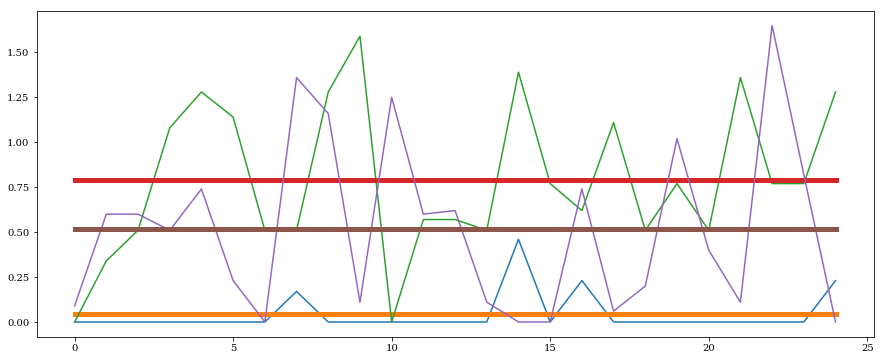

In [13]:
def get_errors(results, errors):
    for e,_,_ in results:
        errors.append(e)        

        
base_errors = []
get_errors(base_results, base_errors)

static_errors = []
get_errors(static_results, static_errors)

runtime_errors = []
get_errors(runtime_results, runtime_errors)


plt.figure(4, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)-1], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)-1], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)-1], [mean, mean], linewidth=5)
plt.show()

In [14]:
def xp2(train_X, train_Y, test_X, test_Y, mode):
    results = []
    for i in range(0,N):
        model = keras.models.load_model(base_dir + mode + str(i) + '_class_lstm.h5')
#         model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X[i], train_Y[i], test_X[i], test_Y[i], mode, i, save=True)
        model.summary()
        train_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        for j in range(0,N):
            print('using model ', str(i), ' on data coming from ', str(j))
            print('-------------------------')
            predict_start = datetime.datetime.now()
            error_ratio = predict(model, test_X[j], test_Y[j])
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print(error_ratio, '% error')
            print('prediction duration = ', predict_duration)
            results.append((error_ratio, train_duration, predict_duration))
    return results

base_results_2 = xp2(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results_2 = xp2(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results_2 = xp2(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')            

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 92ms/step - loss: 0.0013 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 3.2595e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0010 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 1.5532e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0011 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.3740e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0013 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 1.3598e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0014 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 3.6267e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.00

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 94ms/step - loss: 8.4757e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.0921e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0014 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 5.5651e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 4.4939e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.7883e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0013 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 2.5866e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0015 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 2.5230e-04 - val_acc: 1.0000 - val_binary_accura

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:00.006023
using model  1  on data coming from  17
-------------------------
0.0 % error
prediction duration =  0:00:00.004978
using model  1  on data coming from  18
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:00.006049
using model  1  on data coming from  19
-------------------------
Predicting  

Epoch 21/100
49/49 [==============================] - 0s 10ms/step - loss: 2.2164e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.3499e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 0s 10ms/step - loss: 1.2865e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.8306e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 0s 10ms/step - loss: 1.1595e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.4149e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 0s 10ms/step - loss: 1.2582e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1164e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49/49 [==============================] - 0s 10ms/step - loss: 1.0827e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.0689e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 26/100
49

Epoch 10/100
49/49 [==============================] - 1s 10ms/step - loss: 1.9363e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.4068e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 1s 10ms/step - loss: 2.0282e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.1663e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============================] - 1s 10ms/step - loss: 1.3499e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 9.4553e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 13/100
49/49 [==============================] - 1s 10ms/step - loss: 2.4536e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.0702e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 14/100
49/49 [==============================] - 1s 10ms/step - loss: 1.7412e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.7923e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100
49

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 97ms/step - loss: 9.4506e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.0931e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0033 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 4.8558e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0028 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 6.4402e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 6.4528e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.1592e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 6.7104e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.7148e-04 - val_acc: 1.0000 - val_binary_ac

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 100ms/step - loss: 9.5266e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.1471e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 9.6838e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.1058e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 7.5448e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.1008e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 6.0870e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.6820e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 4.6794e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.1175e-04 - val_acc: 1.0000 - val_

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 100ms/step - loss: 3.0222e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.9896e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 3.1817e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.8706e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 3.7373e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 7.3585e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 4.0028e-04 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 10ms/step - loss: 3.8297e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.1212e-04 - val_acc: 1.0000 - val_bina

using model  6  on data coming from  24
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:00.006022
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 101ms/step - loss: 0.0019 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 3.4566e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0021 - acc: 0.9989 - binary_accuracy: 0.9989 - va

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 102ms/step - loss: 8.7443e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 0s 10ms/step - loss: 9.5151e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0015 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0015 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0013 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 10ms/step - loss: 7.4330e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 7.6820e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000


Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 104ms/step - loss: 0.0019 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 0.0016 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0021 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 3.0969e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 0.0016 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 1.5168e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0027 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 3.1343e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 10ms/step - loss: 0.0012 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoc

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 108ms/step - loss: 4.2907e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.4949e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 3.3109e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.9199e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 2.4902e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.9370e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 12ms/step - loss: 2.6650e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6565e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 12ms/step - loss: 2.7236e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.9073e-04 - val_acc: 1.0000 - val_

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
4.17 % error
prediction duration =  0:00:00.006044
using model  10  on data coming from  17
-------------------------
0.0 % error
prediction duration =  0:00:00.004987
using model  10  on data coming from  18
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  [

49/49 [==============================] - 1s 11ms/step - loss: 3.0007e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.0455e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
49/49 [==============================] - 1s 12ms/step - loss: 2.5012e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.5934e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 1s 12ms/step - loss: 1.8693e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.9028e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
49/49 [==============================] - 1s 12ms/step - loss: 2.2388e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.3640e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 1s 11ms/step - loss: 1.7795e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.3799e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==========

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 6s 118ms/step - loss: 0.0025 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 1.6294e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 12ms/step - loss: 0.0021 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 4.4068e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 12ms/step - loss: 9.2346e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 13ms/step - loss: 0.0014 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.1969e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 13ms/step - loss: 0.0017 - acc: 0.9991 - binary_accuracy: 0.9991 - val_loss: 1.0348e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 5s 109ms/step - loss: 4.0244e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1009e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 3.1344e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.4270e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 3.0695e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.3003e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 11ms/step - loss: 2.5293e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.0069e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 11ms/step - loss: 2.2689e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6706e-04 - val_acc: 1.0000 - val_

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.55 % error
prediction duration =  0:00:00.006017
using model  13  on data coming from  19
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting

Epoch 14/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0011 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 2.1054e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0012 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 2.0578e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 16/100
49/49 [==============================] - 1s 11ms/step - loss: 7.1793e-04 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 2.5131e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 17/100
49/49 [==============================] - 1s 11ms/step - loss: 2.4771e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6276e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 18/100
49/49 [==============================] - 1s 11ms/step - loss: 4.3222e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.4575e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 19/100
49/49 [===

Epoch 7/100
49/49 [==============================] - 1s 11ms/step - loss: 6.9590e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.1792e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0021 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 3.9257e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0011 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
49/49 [==============================] - 1s 11ms/step - loss: 8.9888e-04 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0016 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 1s 11ms/step - loss: 3.1859e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.3372e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============

2.08 % error
prediction duration =  0:00:00.006016
using model  15  on data coming from  23
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
0.46 % error
prediction duration =  0:00:00.006043
using model  15  on data coming from  24
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:00.005991
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [=============

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 6s 114ms/step - loss: 0.0016 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 6.0988e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0011 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 7.0786e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 6.1378e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.8333e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 11ms/step - loss: 4.2418e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.4769e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 11ms/step - loss: 5.9203e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 7.7681e-04 - val_acc: 1.0000 - val_binary_a

0.46 % error
prediction duration =  0:00:00.004986
using model  17  on data coming from  24
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.08 % error
prediction duration =  0:00:00.006017
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 6s 117ms/step - loss: 9.3938e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.6750e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - l

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 6s 117ms/step - loss: 0.0080 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0071 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 8.3717e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0014 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 9.4083e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0014 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 7.8776e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0012 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.2134e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000


Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 6s 119ms/step - loss: 8.2849e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.5018e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0039 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0014 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 1.9518e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0016 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 6.4517e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0012 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 6.5192e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 6s 120ms/step - loss: 3.8629e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.6861e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 3.6155e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.2179e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 3.9463e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.9068e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 11ms/step - loss: 3.0301e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.5371e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 11ms/step - loss: 3.0046e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6277e-04 - val_acc: 1.0000 - val_

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 6s 123ms/step - loss: 0.0018 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 5.6357e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0019 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 8.2815e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0022 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 7.4215e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0023 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0026 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0021 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoc

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 6s 123ms/step - loss: 6.1340e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.6599e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 4.0314e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.5591e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 11ms/step - loss: 4.0308e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.4111e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 11ms/step - loss: 5.8693e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.7437e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 11ms/step - loss: 4.1881e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.3571e-04 - val_acc: 1.0000 - val_

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
2.95 % error
prediction duration =  0:00:00.005990
using model  23  on data coming from  20
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth i

49/49 [==============================] - 1s 11ms/step - loss: 0.0029 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0166 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 18/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0013 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0036 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 19/100
49/49 [==============================] - 1s 11ms/step - loss: 1.5972e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
49/49 [==============================] - 1s 11ms/step - loss: 1.9080e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 9.2244e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 21/100
49/49 [==============================] - 1s 11ms/step - loss: 1.5351e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] 

99/99 [==============================] - 7s 69ms/step - loss: 5.4637e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 8.8599e-04 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0030 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 6.5517e-04 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0031 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0015 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 0.0026 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 6.9099e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0017 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 6/100
99/99 [==============================] - 1s 

Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is 

Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'd']
5.14 % error
prediction duration =  0:00:00.067206
using model  0  on data coming from  16
-------------------------
Predicting  ['m2', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 

Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 

99/99 [==============================] - 1s 11ms/step - loss: 2.2221e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.5342e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 16/100
99/99 [==============================] - 1s 11ms/step - loss: 1.3730e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.5178e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 17/100
99/99 [==============================] - 1s 11ms/step - loss: 1.4646e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.1430e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 18/100
99/99 [==============================] - 1s 11ms/step - loss: 2.1960e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.9645e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 19/100
99/99 [==============================] - 1s 11ms/step - loss: 1.3506e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.3741e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
99/99 [========

Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicti

Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
4.69 % error
prediction duration =  0:00:00.069216
using model  1  on data coming from  13
-------------------------
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a',

3.58 % error
prediction duration =  0:00:00.016011
using model  1  on data coming from  21
-------------------------
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m

Epoch 1/100
99/99 [==============================] - 7s 71ms/step - loss: 0.0075 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0044 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0082 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0095 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0070 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0047 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0077 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0046 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0075 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0044 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 6/100
99/99 [==============================] - 1s 11ms

Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
3.66 % error
prediction duration =  0:00:00.016042
using model  2  on data coming from  5
-------------------------
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 

Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
P

Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
5.57 % error
prediction duration =  0:00:00.065174
using model  2  on data coming from  23
-------------------------
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['

99/99 [==============================] - 1s 11ms/step - loss: 0.0068 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0067 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 14/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0068 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0067 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 15/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0068 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0066 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 16/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0067 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0066 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 17/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0067 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0066 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 18/100
99/99 [==============================] - 1s 11ms/step -

Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth i

Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1',

Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
4.43 % error
prediction duration =  0:00:00.016011
using model  3  on data coming from  22
-------------------------
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 

Epoch 1/100
99/99 [==============================] - 7s 72ms/step - loss: 0.0090 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0088 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0089 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0088 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0089 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0089 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0088 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0089 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 6/100
99/99 [==============================] - 1s 11ms

Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m1']
5.48 % error
prediction duration =  0:00:00.031049
using model  4  on data coming from  4
-------------------------
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predict

Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m

Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is

Epoch 1/100
99/99 [==============================] - 7s 72ms/step - loss: 0.0077 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0179 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0085 - acc: 0.9941 - binary_accuracy: 0.9941 - val_loss: 0.0257 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0085 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0109 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0069 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0128 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0069 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0105 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 6/100
99/99 [==============================] - 1s 11ms

Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] 

Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1'] . Truth is  ['m3']
1.14 % error
prediction duration =  0:00:00.014038
using model  5  on data coming from  6
-------------------------
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2'

Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1']
4.43 % error
prediction duration =  0:00:00.065174
using model  5  on data coming from  15
-------------------------
Predicting  ['m1', 'a', 'b', 'c'

Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
3.95 % error
prediction duration =  0:00:00.015039
using model  5  on data coming from  22
-------------------------
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', '

Epoch 10/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0063 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0149 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 11/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0075 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0038 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 12/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0060 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0038 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 13/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0062 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0040 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 14/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0054 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0135 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 15/100
99/99 [==============================] - 1

Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'c']


Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
6.05 % error
prediction duration =  0:00:00.068156
using model  6  on data coming from  23
-------------------------
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'c',

99/99 [==============================] - 1s 12ms/step - loss: 0.0034 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 8/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0033 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 9/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0033 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 10/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0034 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 11/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0033 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 12/100
99/99 [==============================] - 1s 12ms/step - l

Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b',

Predicting  ['m2', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd'

Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b',

99/99 [==============================] - 1s 12ms/step - loss: 0.0106 - acc: 0.9936 - binary_accuracy: 0.9936 - val_loss: 0.0116 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 22/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0111 - acc: 0.9932 - binary_accuracy: 0.9932 - val_loss: 0.0110 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 23/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0108 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0110 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 24/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0110 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0103 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 25/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0119 - acc: 0.9927 - binary_accuracy: 0.9927 - val_loss: 0.0104 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 26/100
99/99 [==============================] - 1s 12ms/step -

99/99 [==============================] - 1s 12ms/step - loss: 0.0031 - acc: 0.9984 - binary_accuracy: 0.9984 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00064: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_66 (TimeDis (None, 18, 250)           5750      
_________________________________________________________________
cu_dnnlstm_33 (CuDNNLSTM)    (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_67 (TimeDis (None, 18, 50)            6300      
_________________________________________________________________
dense_101 (Dense)            (None, 18, 8)             408       
Total params: 200,958
Trainable params: 200,958
Non-trainable params: 0
_________________________________________________________________
using model  8  on data coming from  0
-------------------------

Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd',

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['

Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'b']
5.09 % error
prediction duration =  0:00:00.016043
using model  8  on data coming from  22
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2'

Epoch 1/100
99/99 [==============================] - 8s 76ms/step - loss: 0.0070 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0051 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0057 - acc: 0.9960 - binary_accuracy: 0.9960 - val_loss: 0.0051 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0059 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.0096 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0077 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0054 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0057 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0060 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 6/100
99/99 [==============================] - 1s 12ms

Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'b'] . Truth is  ['m2']
Predicting  ['m3', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'b'] . Truth is  ['m2']
Predicting  ['m3', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'b'] . Truth is  ['m1']
4.18 % error
prediction duration =  0:00:00.032058
using model  9  on data coming from  4
-------------------------
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2'

Predicting  ['m3', 'b'] . Truth is  ['m2']
Predicting  ['m3', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'b'] . Truth is  ['m2']
Predicting  ['m3', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
4.43 % error
prediction duration =  0:00:00.069184
using model  9  on data coming from  14
-------------------------
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting

Predicting  ['m2'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2'] . Truth i

Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0028 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 3.7667e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0014 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 6.8886e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0012 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 3.9136e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0018 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0011 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0011 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 3.9517e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
99/99 [=========================

Predicting  ['m1', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b']
3.89 % error
prediction duration =  0:00:00.016068
using model  10  on data coming from  5
-------------------------
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1',

Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
3.44 % error
prediction duration =  0:00:00.069215
using model  10  on data coming from  14
-------------------------
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'c']
Predic

Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
3.27 % error
prediction duration =  0:00:00.015068
using model  10  on data coming from  23

99/99 [==============================] - 1s 12ms/step - loss: 0.0048 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0046 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 14/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0052 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0046 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 15/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0050 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0049 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 16/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0048 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 17/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0055 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0038 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 18/100
99/99 [==============================] - 1s 12ms/step -

Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', '

Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
3.66 % error
prediction duration =  0:00:00.071718
using model  11  on data coming from  15
-------------------------
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting 

Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m

Epoch 1/100
99/99 [==============================] - 9s 95ms/step - loss: 0.0035 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0034 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0037 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 3/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0034 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0036 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0035 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 6/100
99/99 [==============================] - 1s 13ms

Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a'

Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predic

Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . 

Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m

Epoch 1/100
99/99 [==============================] - 8s 78ms/step - loss: 0.0033 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0033 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0032 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0033 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0033 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 6/100
99/99 [==============================] - 1s 11ms

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']


Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c',

Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
3.66 % error
prediction duration =  0:00:00.078135
using model  13  on data coming from  22
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'e'] 

99/99 [==============================] - 9s 87ms/step - loss: 0.0060 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0034 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0036 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0039 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0035 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0035 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0034 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 6/100
99/99 [==============================] - 1s 11ms/step - loss

Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Pre

Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth

Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m2', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m2',

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2

Epoch 20/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0050 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0048 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 21/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0050 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0048 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 22/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0049 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0048 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 23/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0052 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0048 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 24/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0049 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0048 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 25/100
99/99 [==============================] - 1

Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'b', '

Predicting  ['m1', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', '

Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'b'

Epoch 1/100
99/99 [==============================] - 9s 86ms/step - loss: 0.0067 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0050 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 2/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0070 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0052 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 3/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0064 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0047 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0067 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0048 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0077 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.0115 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 6/100
99/99 [==============================] - 1s 12ms

Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['

Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 

Predicting  ['m1', 'a'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting 

Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0071 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0056 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 8/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0066 - acc: 0.9955 - binary_accuracy: 0.9955 - val_loss: 0.0072 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 9/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0072 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0052 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 10/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0069 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0052 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 11/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0075 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0075 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 12/100
99/99 [==============================] - 1s 1

Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2',

Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m3', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c']

Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']


Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 9s 88ms/step - loss: 0.0033 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0032 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0035 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0033 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0034 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0033 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 6/100
99/9

Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'e'] . Truth is  ['m1

Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m3', 'a', 'b', 'c'] . Truth is  ['m2', '

Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b

99/99 [==============================] - 1s 11ms/step - loss: 0.0047 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0052 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0049 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0050 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0051 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0051 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 6/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0049 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0051 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 7/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0046 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0052 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 8/100
99/99 [==============================] - 1s 12ms/step - loss

99/99 [==============================] - 1s 11ms/step - loss: 2.3766e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 47/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0015 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 1.7790e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 48/100
99/99 [==============================] - 1s 12ms/step - loss: 1.6613e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.5373e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 49/100
99/99 [==============================] - 1s 12ms/step - loss: 1.5062e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.2987e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 50/100
99/99 [==============================] - 1s 12ms/step - loss: 1.2162e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.3282e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 51/100
99/99 [================

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Tr

Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Pre

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
2.56 % error
prediction duration =  0:00:00.016015
using model  19  on data coming fro

99/99 [==============================] - 1s 12ms/step - loss: 0.0038 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 14/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0035 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 15/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0035 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 16/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0037 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0035 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 17/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0035 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 18/100
99/99 [==============================] - 1s 12ms/step -

Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
5.8 % error
prediction duration =  0:00:00.071157
using model  20  on data coming from  13
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . 

Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
5.54 % error
prediction duration =  0:00:00.075202
using model  20  on data coming from  20
-------------------------
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
0.51 % error
prediction duration =  0:00:00.016034
using model  20  on data coming from  21
-------------------------
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m3']
Predicti

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 9s 92ms/step - loss: 0.0089 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0088 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0090 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0093 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0091 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0090 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0090 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0089 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0087 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 6/100
99/9

99/99 [==============================] - 1s 13ms/step - loss: 0.0033 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0040 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 45/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0034 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0034 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 46/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0033 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 47/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0033 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0032 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 48/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0033 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0033 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 49/100
99/99 [==============================] - 1s 13ms/step -

2.61 % error
prediction duration =  0:00:00.016013
using model  21  on data coming from  4
-------------------------
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'b']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  [

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'a', 

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'a', 'e']
4.55 % error
prediction duration =  0:00:00.022059
using model  21  on data coming from  21
-------------------------
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3']
0.51 % error
prediction duration =  0:00:00.016043
using model  21  on data coming from  22
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['

Epoch 1/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0050 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0047 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0050 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0047 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0051 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0048 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 4/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0052 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0048 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 11ms/step - loss: 0.0048 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0049 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 6/100
99/99 [==============================] - 1s 11ms

Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a

Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a'

Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . 

Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'e']
4.29 % error
prediction duration =  0:00:00.0741

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 10s 97ms/step - loss: 0.0068 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0074 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0067 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0079 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0059 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0075 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0057 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0073 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0055 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0086 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 6/100
99/

Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'c'] . Truth is  ['m1', 'b']
5.51 % error
prediction duration =  0:00:00.017079
using model  23  on data coming from  5
-------------------------
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m

Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'c'] . Truth is  ['m1']
Predicting  ['m1', 

Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  [

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 9s 93ms/step - loss: 0.0092 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0094 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0093 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0088 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0092 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0090 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0093 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0092 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 6/100
99/9

Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m1']
3.38 % error
prediction duration =  0:00:00.029043
using model  24  on data coming from  3
-------------------------
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predi

Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a

Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b'] . Truth is  [

Epoch 1/100
99/99 [==============================] - 9s 90ms/step - loss: 0.0026 - acc: 0.9988 - binary_accuracy: 0.9988 - val_loss: 3.0810e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 9.8148e-04 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 2.2787e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0027 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 9.2528e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0011 - acc: 0.9995 - binary_accuracy: 0.9995 - val_loss: 4.2594e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 6.5299e-04 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 2.0819e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
99/99 [=============

Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'c', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 

Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
5.17 % error
prediction duration =  0:00:00.062167
using model  0  on data coming from  14
-------------------------
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m

Predicting  ['m2', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'c'

Epoch 1/100
99/99 [==============================] - 10s 97ms/step - loss: 0.0054 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0051 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0084 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0051 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0053 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0060 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0060 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0055 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0055 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0052 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 6/100
99/99 [==============================] - 1s 12m

Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is

Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth 

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
5.48 % error
prediction duration =  0:00:00.063167
using model  1  on data coming from  22
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth

99/99 [==============================] - 1s 14ms/step - loss: 0.0081 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0142 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0088 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0134 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0069 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0226 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 6/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0085 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0150 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 7/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0069 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0144 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 8/100
99/99 [==============================] - 1s 14ms/step - loss

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2'] . Truth is  ['m1', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  [

Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
5.71 % error
p

Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m1', 'a', 'e']
6.34 % error
prediction duration =  0:00:00.067179
using model  2  on data coming from  23
-------------------------
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'e']
Predic

99/99 [==============================] - 1s 13ms/step - loss: 0.0048 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0040 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0046 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0040 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0048 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0040 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0038 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0038 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss

Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
P

using model  3  on data coming from  13
-------------------------
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1

Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd', '

Epoch 1/100
99/99 [==============================] - 9s 94ms/step - loss: 0.0064 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0043 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 2/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0061 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0045 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 3/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0060 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0045 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 4/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0058 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0040 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 5/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0063 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0050 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 6/100
99/99 [==============================] - 1s 12ms

Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m2', '

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Tru

Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1',

Predicting  ['m3', 'a', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m2']
Predicting  ['m3', 'a', 'e'] . Truth is  ['m3']
Predicting  ['m1

Epoch 7/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0030 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0017 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0037 - acc: 0.9981 - binary_accuracy: 0.9981 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0029 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0022 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 10/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0120 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0226 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 11/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0087 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0027 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 12/100
99/99 [==============================] - 1s 1

Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
2.5 % error
prediction duration =  0:00:00.015042
using model  5  on data coming from  5
-------------------------
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predict

3.52 % error
prediction duration =  0:00:00.064197
using model  5  on data coming from  16
-------------------------
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b', 'c']

Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
4.23 % error
prediction duration =  0:00:00.017012
using model  5  on data coming from  23
-------------------------
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a']
Pr

99/99 [==============================] - 1s 13ms/step - loss: 0.0056 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0770 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 24/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0568 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 25/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0044 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0821 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 26/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0039 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0734 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 27/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0866 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 28/100
99/99 [==============================] - 1s 13ms/step -

Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'd']
3.72 % error
prediction duration =  0:00:00.021057
using model  6  on data coming from  4
-------------------------
Predicting  ['m1', 'c'] . Truth is  ['m1', 'a', 'c', 

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c', 'd']
Pre

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['

99/99 [==============================] - 1s 13ms/step - loss: 0.0166 - acc: 0.9930 - binary_accuracy: 0.9930 - val_loss: 0.0120 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0162 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0128 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0143 - acc: 0.9932 - binary_accuracy: 0.9932 - val_loss: 0.0124 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 8/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0149 - acc: 0.9933 - binary_accuracy: 0.9933 - val_loss: 0.0116 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 9/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0139 - acc: 0.9939 - binary_accuracy: 0.9939 - val_loss: 0.0115 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 10/100
99/99 [==============================] - 1s 13ms/step - los

Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2

Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['

Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
4.43 % error
prediction duration =  0:00:00.067180
using model  7  on data coming from  14
-------------------------
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c',

Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
3.44 % error
prediction duration =  0:00:00.016042
using model  7  on data coming from  22
-------------------------
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  [

Epoch 1/100
99/99 [==============================] - 10s 101ms/step - loss: 0.0133 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.1786 - val_acc: 0.9676 - val_binary_accuracy: 0.9676
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0130 - acc: 0.9932 - binary_accuracy: 0.9932 - val_loss: 0.1961 - val_acc: 0.9525 - val_binary_accuracy: 0.9525
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0117 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.1859 - val_acc: 0.9578 - val_binary_accuracy: 0.9578
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0127 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.1861 - val_acc: 0.9693 - val_binary_accuracy: 0.9693
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0120 - acc: 0.9936 - binary_accuracy: 0.9936 - val_loss: 0.1901 - val_acc: 0.9664 - val_binary_accuracy: 0.9664
Epoch 6/100
99/99 [==============================] - 1s 13

99/99 [==============================] - 1s 14ms/step - loss: 0.0078 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.1565 - val_acc: 0.9809 - val_binary_accuracy: 0.9809
Epoch 45/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0085 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.1355 - val_acc: 0.9809 - val_binary_accuracy: 0.9809
Epoch 46/100
99/99 [==============================] - 1s 12ms/step - loss: 0.0097 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.1324 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 47/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0080 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.1349 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 48/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0079 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.1435 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 49/100
99/99 [==============================] - 1s 14ms/step -

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1',

Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m

Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'e']
4.94 % error
prediction duration =  0:00:00.073196
using model  8  on data coming from  20
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  [

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 10s 99ms/step - loss: 0.0020 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0018 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0027 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0010 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0018 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 4.2214e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0019 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 5.9782e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0018 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 7.3986e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epo

Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
3.04 % error
prediction duration =  0:00:00.042127
using model  9  on data coming from  5
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1

Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  [

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . T

99/99 [==============================] - 1s 13ms/step - loss: 0.0073 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0224 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 13/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0071 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0241 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 14/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0073 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0241 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 15/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0075 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0181 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0119 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0258 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 17/100
99/99 [==============================] - 1s 13ms/step -

Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd'] . T

Predicting  ['m1', 'c', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
5.0 % error
prediction duration =  0:00:00.018043
using model  10  on data coming from  14
-------------------------
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m3']
Predicting  ['m1',

Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth i

Epoch 1/100
99/99 [==============================] - 10s 99ms/step - loss: 0.0050 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0163 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0242 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0050 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0172 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0048 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0179 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0046 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0259 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 6/100
99/99 [==============================] - 1s 13m

Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b', 'e'] . Truth is  ['m1', 'b',

Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m3']
Predicting  ['m1'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
6.14 % error
prediction duration =  0:00:00.064171
using model  11  on data coming from  14
-------------------------
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'

Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Pre

Epoch 1/100
99/99 [==============================] - 10s 101ms/step - loss: 0.0040 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0155 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0041 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0155 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0040 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0217 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0039 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0163 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0041 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0148 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 6/100
99/99 [==============================] - 1s 13

Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m1', 'b', 'c'

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m3', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 

Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 10s 102ms/step - loss: 0.0037 - acc: 0.9984 - binary_accuracy: 0.9984 - val_loss: 0.0038 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0029 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0150 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0032 - acc: 0.9985 - binary_accuracy: 0.9985 - val_loss: 0.0018 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0035 - acc: 0.9981 - binary_accuracy: 0.9981 - val_loss: 0.0154 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0034 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0060 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 6/100
99

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
5.0 % error
prediction duration =  0:00:00.063163
using model  13  on data coming from  5
-------------------------
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  

Predicting  ['m1', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1'

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
6.31 % error
prediction duration =  0:00:00.065139
using model  13  on data coming from  21
-------------------------
Predicting  ['m3', 'c'] .

Epoch 1/100
99/99 [==============================] - 10s 102ms/step - loss: 0.0016 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0021 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0026 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0022 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0015 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0026 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0013 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0064 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0019 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 0.0039 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 6/100
99/99 [==============================] - 1s 13

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b', 

Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'e']
4.23 % error
prediction duration =  0:00:00.063167
using model  14  on data coming from  12
-------------------------
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting 

Predicting  ['m1', 'a', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
4.74 % error
prediction duration =  0:00:00.067179
using model  14  on data coming from  22
-------------------------
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predict

Epoch 1/100
99/99 [==============================] - 10s 103ms/step - loss: 0.0067 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0131 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0057 - acc: 0.9984 - binary_accuracy: 0.9984 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0058 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0080 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0055 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0072 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0058 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 6/100
99/99 [==============================] - 1s 13

Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'e']
3.81 % error
prediction duration =  0:00:00.015040
using model  15  on data coming from  5
-------------------------
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth 

Predicting  ['m1', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['

Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c'] 

Epoch 1/100
99/99 [==============================] - 10s 104ms/step - loss: 0.0051 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0066 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0048 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0046 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0048 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0025 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0049 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0027 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0051 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0024 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
99/99 [==============================] - 1s 13

using model  16  on data coming from  5
-------------------------
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m3', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c

Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'b', 

Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'e']

Epoch 1/100
99/99 [==============================] - 10s 105ms/step - loss: 0.0030 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0025 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0027 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0046 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0094 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0254 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0094 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0020 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0027 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
99/99 [==============================] - 1s 13

prediction duration =  0:00:00.030046
using model  17  on data coming from  5
-------------------------
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', '

Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
4.97 % error
prediction duration =  0:00:00.066208
using model  17  on data coming from  14
-------------------------
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Pred

Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a']
Predicting  ['m1', 'a', 'b', 'd', 'e'] . Truth is  

99/99 [==============================] - 1s 13ms/step - loss: 0.0040 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0035 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 18/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0036 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 5.0836e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 19/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0034 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0022 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0073 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 7.2148e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 21/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0035 - acc: 0.9984 - binary_accuracy: 0.9984 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
99/99 [==============================] - 1s 13m

Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
4.38 % error
prediction duration =  0:00:00.040107
using model  18  on data coming from  4
-------------------------
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'b'] .

Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b'

Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2

99/99 [==============================] - 1s 13ms/step - loss: 0.0097 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0133 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0099 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0103 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0096 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0100 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0096 - acc: 0.9936 - binary_accuracy: 0.9936 - val_loss: 0.0118 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0092 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0105 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss

Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a

Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'd']
Predicting  ['m1'] . Truth is  ['m1', 'c', 'e']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1'] . Truth is  ['m1', 'c', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'd']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e

Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 11s 108ms/step - loss: 0.0035 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0025 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0036 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0023 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0069 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0035 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0097 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0034 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0034 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0047 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 6/100
99

Predicting  ['m1', 'd'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'c', 'd

Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a

Epoch 1/100
99/99 [==============================] - 11s 109ms/step - loss: 0.0039 - acc: 0.9981 - binary_accuracy: 0.9981 - val_loss: 0.0082 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0041 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0076 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0041 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0065 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0040 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0091 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0040 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0073 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 6/100
99/99 [==============================] - 1s 13

Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b'

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'd']
5.31 % error
prediction duration =  0:00:00.067224
using model  21  on data coming from  21
-------------------------
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m2'

Epoch 1/100
99/99 [==============================] - 11s 111ms/step - loss: 0.0162 - acc: 0.9907 - binary_accuracy: 0.9907 - val_loss: 0.0168 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0164 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0277 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0154 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0369 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0160 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0522 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0152 - acc: 0.9913 - binary_accuracy: 0.9913 - val_loss: 0.0385 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 6/100
99/99 [==============================] - 1s 13

99/99 [==============================] - 1s 13ms/step - loss: 0.0099 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0542 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 45/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0086 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.0342 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 46/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0084 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0438 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 47/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0085 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0361 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 48/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0085 - acc: 0.9960 - binary_accuracy: 0.9960 - val_loss: 0.0675 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 49/100
99/99 [==============================] - 1s 13ms/step -

Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
4.06 % error
prediction duration =  0:00:00.016042
using model  22  on data coming from  5
-------------------------
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c',

Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
4.69 % error
prediction duration =  0:00:00.067195
using model  22  on d

Predicting  ['m2', 'a', 'c'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'd']
3.64 % error
prediction duration =  0:00:00.017046
using model  22  on data coming from  21
-------------------------
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'

99/99 [==============================] - 1s 13ms/step - loss: 0.0119 - acc: 0.9936 - binary_accuracy: 0.9936 - val_loss: 0.0150 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0103 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0117 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0115 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0226 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0125 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0145 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0117 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0151 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss

Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'c']
Predicting 

Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b'

Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'c']
Pr

Epoch 1/100
99/99 [==============================] - 11s 112ms/step - loss: 0.0022 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0050 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0025 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0047 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0022 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0054 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0017 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 0.0039 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0017 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 0.0028 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 6/100
99/99 [==============================] - 1s 13

Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m3']
Predictin

Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicti

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m1'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Tru

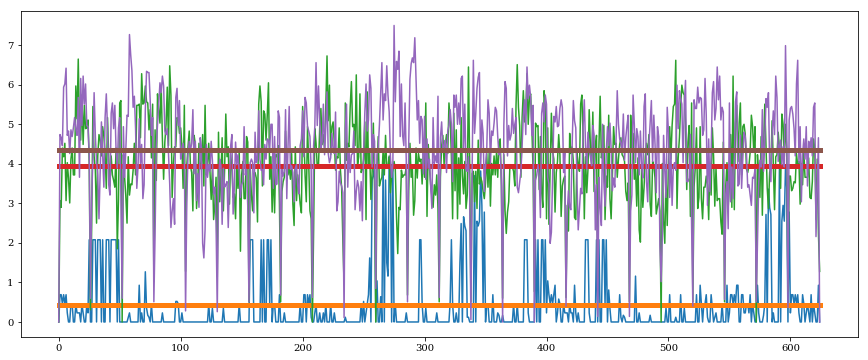

In [15]:
base_errors_2 = []
get_errors(base_results_2, base_errors_2)

static_errors_2 = []
get_errors(static_results_2, static_errors_2)

runtime_errors_2 = []
get_errors(runtime_results_2, runtime_errors_2)


plt.figure(5, figsize=(15,6))
plt.plot(base_errors_2)
mean = np.mean(base_errors_2)
plt.plot([0, len(base_errors_2)-1], [mean, mean], linewidth=5)
plt.plot(static_errors_2)
mean = np.mean(static_errors_2)
plt.plot([0, len(static_errors_2)-1], [mean, mean], linewidth=5)
plt.plot(runtime_errors_2)
mean = np.mean(runtime_errors_2)
plt.plot([0, len(runtime_errors_2)-1], [mean, mean], linewidth=5)
plt.show()

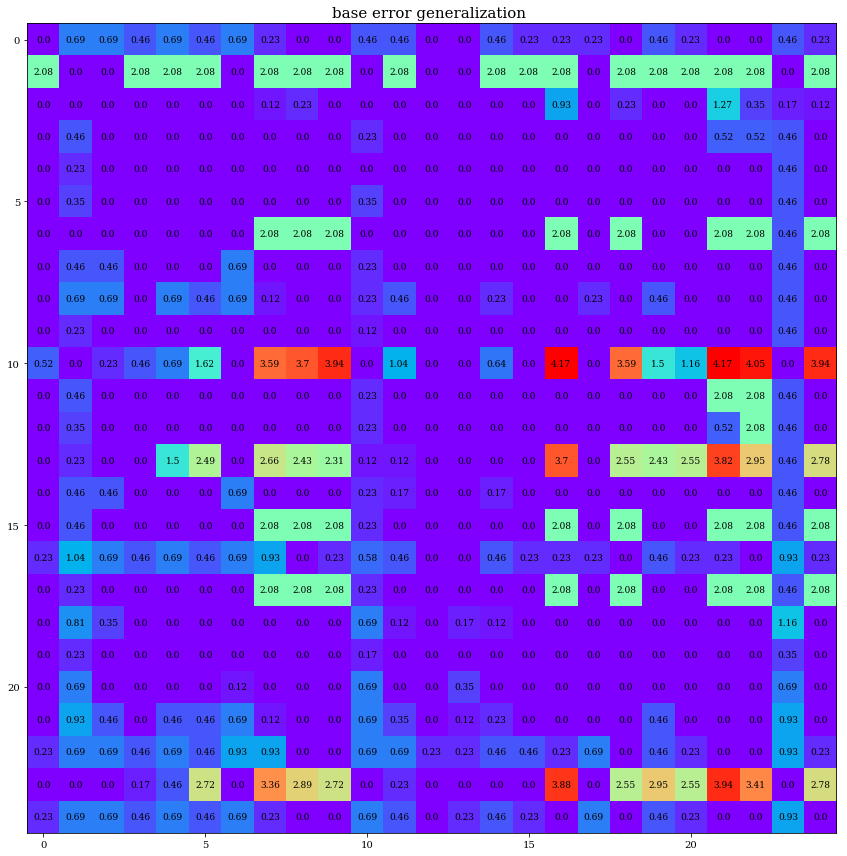

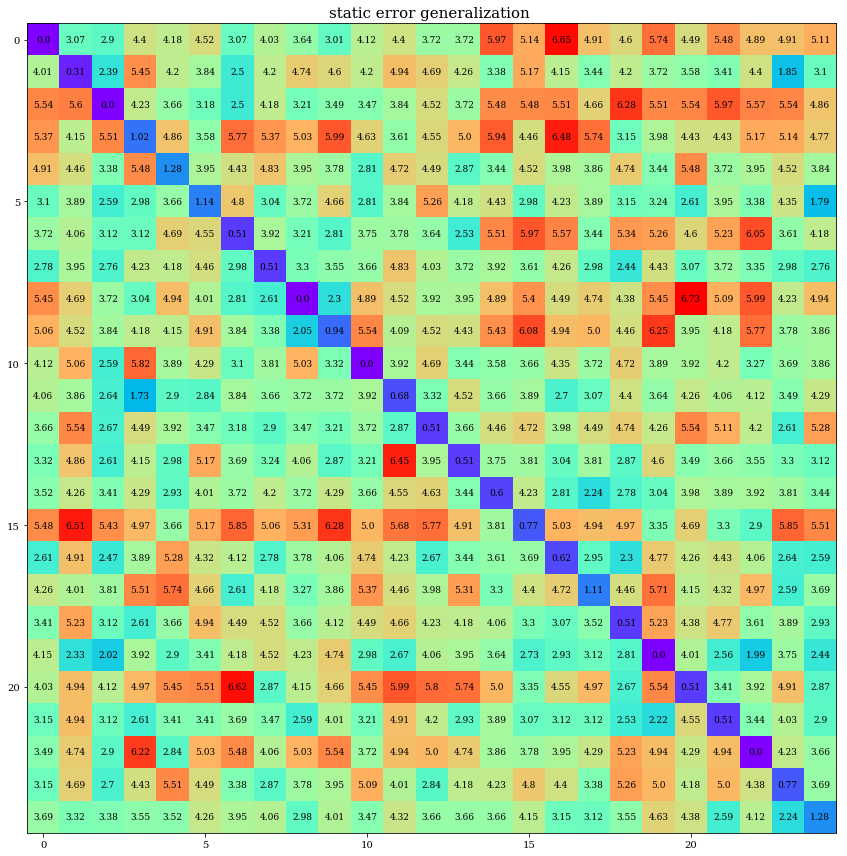

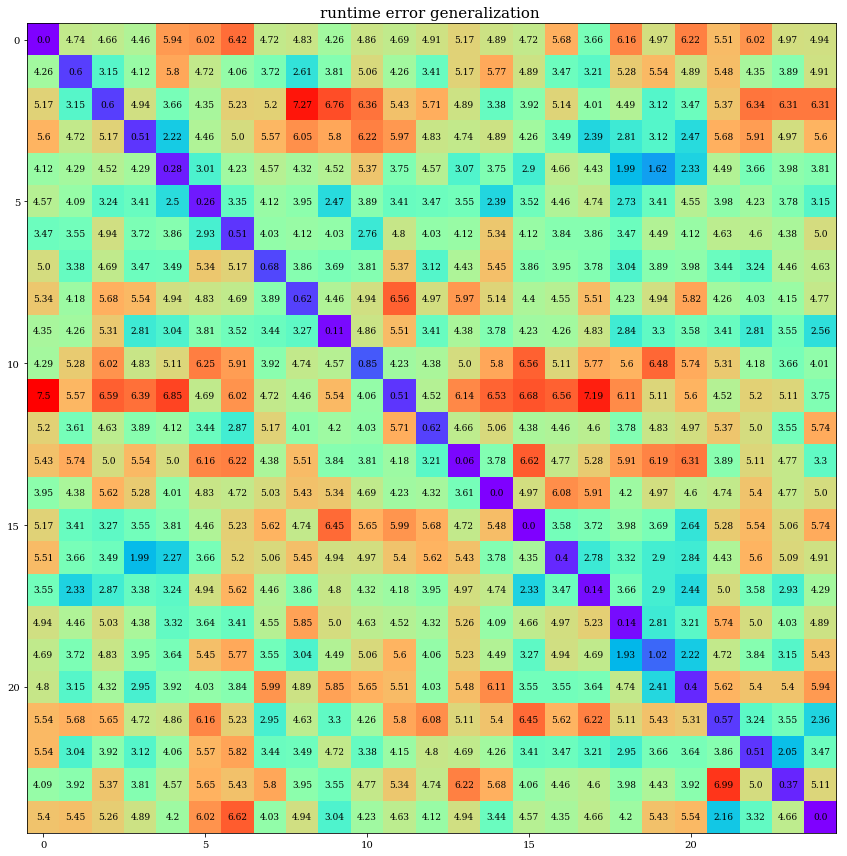

In [16]:
def get_error_matrices(errors, error_matrix):
    for i in range(0,N):
        for j in range(0,N):
            error_matrix[i][j] = errors[N*i+j]
            
base_error_matrix = np.empty([N,N], dtype=float)
get_error_matrices(base_errors_2, base_error_matrix)

static_error_matrix = np.empty([N,N], dtype=float)
get_error_matrices(static_errors_2, static_error_matrix)

runtime_error_matrix = np.empty([N,N], dtype=float)
get_error_matrices(runtime_errors_2, runtime_error_matrix)

def plot_matrices(error_matrix, mode):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,N):
        for j in range(0,N):
            text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" error generalization ", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_error_generalization_class_xp2.png', dpi=300)
    
plot_matrices(base_error_matrix, 'base')
plot_matrices(static_error_matrix, 'static')    
plot_matrices(runtime_error_matrix, 'runtime')  

In [17]:
def xp3(train_X, train_Y, test_X, test_Y, mode):
    results = []
    for i in range(0,N,5):    
        model = keras_model(train_X[i].shape[2], train_Y[i].shape[2])
        train_start = datetime.datetime.now()
        for j in range(i,i+5):
            model = train_and_save(model, train_X[j], train_Y[j], test_X[j], test_Y[j], mode, 100*i+j, save=False)
        model.summary()
        train_stop = datetime.datetime.now()
        train_duration = train_stop - train_start            
        for j in range(0,N):
            print('using model ', str(i), '-', str(i+4), ' on data coming from ', str(j))
            print('-------------------------')
            predict_start = datetime.datetime.now()
            error_ratio = predict(model, test_X[j], test_Y[j])
            predict_stop = datetime.datetime.now()
            predict_duration = predict_stop - predict_start
            print(error_ratio, '% error')
            print('prediction duration = ', predict_duration)
            results.append((error_ratio, train_duration, predict_duration))
    return results

base_results_3 = xp3(base_X_train_supervised, base_Y_train_supervised, base_X_test_supervised, base_Y_test_supervised, 'base')
static_results_3 = xp3(static_X_train_supervised, static_Y_train_supervised, static_X_test_supervised, static_Y_test_supervised, 'static')
runtime_results_3 = xp3(runtime_X_train_supervised, runtime_Y_train_supervised, runtime_X_test_supervised, runtime_Y_test_supervised, 'runtime')      

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 4s 78ms/step - loss: 0.5957 - acc: 0.6835 - binary_accuracy: 0.6835 - val_loss: 0.5589 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 1s 13ms/step - loss: 0.5424 - acc: 0.7085 - binary_accuracy: 0.7085 - val_loss: 0.4953 - val_acc: 0.7106 - val_binary_accuracy: 0.7106
Epoch 3/100
49/49 [==============================] - 1s 14ms/step - loss: 0.2079 - acc: 0.9137 - binary_accuracy: 0.9137 - val_loss: 0.0402 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
49/49 [==============================] - 1s 13ms/step - loss: 0.0282 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0202 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0187 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0163 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
49/49

49/49 [==============================] - 1s 14ms/step - loss: 0.0014 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 6.1139e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0012 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 9.2413e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
49/49 [==============================] - 1s 13ms/step - loss: 0.0010 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 8.8950e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
49/49 [==============================] - 1s 13ms/step - loss: 0.0015 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 4.9004e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
49/49 [==============================] - 1s 13ms/step - loss: 5.6772e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.9423e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [=============================

49/49 [==============================] - 1s 13ms/step - loss: 5.1362e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.7683e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
49/49 [==============================] - 1s 14ms/step - loss: 4.8004e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.6763e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 21/100
49/49 [==============================] - 1s 14ms/step - loss: 4.6819e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.0499e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 1s 13ms/step - loss: 4.8780e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.2651e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 1s 13ms/step - loss: 4.3896e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.2784e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [========

Epoch 8/100
49/49 [==============================] - 1s 14ms/step - loss: 5.9092e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.3615e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 1s 14ms/step - loss: 6.1414e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.6489e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
49/49 [==============================] - 1s 13ms/step - loss: 5.4778e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.6206e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 1s 13ms/step - loss: 5.3372e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.3920e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============================] - 1s 14ms/step - loss: 4.8512e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.2391e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 13/100
49/4

Epoch 2/100
49/49 [==============================] - 1s 14ms/step - loss: 0.5324 - acc: 0.7106 - binary_accuracy: 0.7106 - val_loss: 0.4489 - val_acc: 0.7882 - val_binary_accuracy: 0.7882
Epoch 3/100
49/49 [==============================] - 1s 13ms/step - loss: 0.1604 - acc: 0.9405 - binary_accuracy: 0.9405 - val_loss: 0.0361 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 4/100
49/49 [==============================] - 1s 15ms/step - loss: 0.0249 - acc: 0.9909 - binary_accuracy: 0.9909 - val_loss: 0.0240 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 5/100
49/49 [==============================] - 1s 15ms/step - loss: 0.0196 - acc: 0.9897 - binary_accuracy: 0.9897 - val_loss: 0.0168 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0182 - acc: 0.9902 - binary_accuracy: 0.9902 - val_loss: 0.0166 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 7/100
49/49 [==============================] - 1s 14ms

49/49 [==============================] - 1s 14ms/step - loss: 6.2241e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.8236e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 46/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0010 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.4129e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 47/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0017 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 8.5816e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00047: early stopping
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0019 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 8.4218e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 14ms/step - loss: 4.1680e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.4829e-04 - val_acc: 1.0000 -

49/49 [==============================] - 1s 14ms/step - loss: 1.9488e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.8107e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 14/100
49/49 [==============================] - 1s 14ms/step - loss: 2.0137e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.3025e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100
49/49 [==============================] - 1s 14ms/step - loss: 1.3160e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 7.0652e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 16/100
49/49 [==============================] - 1s 13ms/step - loss: 1.3654e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 8.9840e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 17/100
49/49 [==============================] - 1s 13ms/step - loss: 1.0713e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 4.0358e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 18/100
49/49 [========

Epoch 2/100
49/49 [==============================] - 1s 14ms/step - loss: 3.5230e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.2039e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 14ms/step - loss: 3.1029e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.5952e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 14ms/step - loss: 3.2070e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.3540e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 14ms/step - loss: 3.1810e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.7139e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
49/49 [==============================] - 1s 14ms/step - loss: 2.3884e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 9.2064e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
49/49 [=

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 4s 86ms/step - loss: 0.5964 - acc: 0.6956 - binary_accuracy: 0.6956 - val_loss: 0.5400 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 1s 17ms/step - loss: 0.3524 - acc: 0.8353 - binary_accuracy: 0.8353 - val_loss: 0.0860 - val_acc: 0.9850 - val_binary_accuracy: 0.9850
Epoch 3/100
49/49 [==============================] - 1s 16ms/step - loss: 0.0317 - acc: 0.9889 - binary_accuracy: 0.9889 - val_loss: 0.0211 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
49/49 [==============================] - 1s 16ms/step - loss: 0.0171 - acc: 0.9888 - binary_accuracy: 0.9888 - val_loss: 0.0182 - val_acc: 0.9861 - val_binary_accuracy: 0.9861
Epoch 5/100
49/49 [==============================] - 1s 15ms/step - loss: 0.0152 - acc: 0.9904 - binary_accuracy: 0.9904 - val_loss: 0.0156 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
49/49

49/49 [==============================] - 1s 14ms/step - loss: 0.0031 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0029 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 17ms/step - loss: 0.0022 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0013 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0014 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0039 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 7/100
49/49 [==============================] - 1s 16ms/step - loss: 6.3952e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0010 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 8/100
49/49 [==============================] - 1s 16ms/step - loss: 6.9202e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0046 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 1s 15ms/ste

Epoch 20/100
49/49 [==============================] - 1s 13ms/step - loss: 5.9650e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.6583e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 21/100
49/49 [==============================] - 1s 13ms/step - loss: 4.5850e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.6860e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 22/100
49/49 [==============================] - 1s 13ms/step - loss: 4.7039e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.4587e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
49/49 [==============================] - 1s 13ms/step - loss: 5.4351e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.9711e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
49/49 [==============================] - 1s 13ms/step - loss: 6.6417e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6807e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 25/100
49

49/49 [==============================] - 1s 15ms/step - loss: 3.5370e-06 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.5646e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 9/100
49/49 [==============================] - 1s 14ms/step - loss: 3.5207e-06 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.3431e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 10/100
49/49 [==============================] - 1s 15ms/step - loss: 3.4423e-06 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.2959e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
49/49 [==============================] - 1s 15ms/step - loss: 3.3528e-06 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.2540e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============================] - 1s 15ms/step - loss: 3.2196e-06 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.0413e-06 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 13/100
49/49 [=========

49/49 [==============================] - 1s 14ms/step - loss: 0.5449 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5016 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 1s 14ms/step - loss: 0.2303 - acc: 0.9043 - binary_accuracy: 0.9043 - val_loss: 0.0369 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0276 - acc: 0.9909 - binary_accuracy: 0.9909 - val_loss: 0.0204 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 5/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0203 - acc: 0.9872 - binary_accuracy: 0.9872 - val_loss: 0.0167 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 6/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0174 - acc: 0.9884 - binary_accuracy: 0.9884 - val_loss: 0.0157 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 7/100
49/49 [==============================] - 1s 14ms/step - loss

49/49 [==============================] - 1s 14ms/step - loss: 0.0052 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 4.3024e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 46/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0018 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 5.1167e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00046: early stopping
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 14ms/step - loss: 7.2938e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 7.8583e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 13ms/step - loss: 6.1834e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 5.3570e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0012 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 4.8890e-05 - val_acc: 1.0000 - 

49/49 [==============================] - 1s 14ms/step - loss: 1.5475e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.4598e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100
49/49 [==============================] - 1s 13ms/step - loss: 1.5083e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.3354e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 16/100
49/49 [==============================] - 1s 14ms/step - loss: 1.3804e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.2464e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 17/100
49/49 [==============================] - 1s 13ms/step - loss: 1.2819e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.1624e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 18/100
49/49 [==============================] - 1s 13ms/step - loss: 1.1949e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.1111e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 19/100
49/49 [========

Epoch 2/100
49/49 [==============================] - 1s 13ms/step - loss: 6.1145e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.0358e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 14ms/step - loss: 5.4882e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.4911e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 14ms/step - loss: 3.7818e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.5295e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 5/100
49/49 [==============================] - 1s 14ms/step - loss: 4.3421e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.0445e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
49/49 [==============================] - 1s 14ms/step - loss: 3.2074e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.5738e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 7/100
49/49 [=

Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 4s 80ms/step - loss: 0.5888 - acc: 0.6939 - binary_accuracy: 0.6939 - val_loss: 0.5585 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
49/49 [==============================] - 1s 13ms/step - loss: 0.5477 - acc: 0.7083 - binary_accuracy: 0.7083 - val_loss: 0.5183 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 3/100
49/49 [==============================] - 1s 14ms/step - loss: 0.2603 - acc: 0.8778 - binary_accuracy: 0.8778 - val_loss: 0.0402 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 4/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0308 - acc: 0.9877 - binary_accuracy: 0.9877 - val_loss: 0.0219 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 5/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0213 - acc: 0.9899 - binary_accuracy: 0.9899 - val_loss: 0.0186 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 6/100
49/49

49/49 [==============================] - 1s 14ms/step - loss: 0.0022 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 0.0355 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 45/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0277 - acc: 0.9936 - binary_accuracy: 0.9936 - val_loss: 0.0048 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 46/100
49/49 [==============================] - 1s 13ms/step - loss: 0.0046 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0020 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 47/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0017 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.2291e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 48/100
49/49 [==============================] - 1s 14ms/step - loss: 0.0017 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 6.4931e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00048: early stopping
Train on 49 samples, validate on

49/49 [==============================] - 1s 13ms/step - loss: 5.9776e-04 - acc: 0.9999 - binary_accuracy: 0.9999 - val_loss: 1.7566e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 12/100
49/49 [==============================] - 1s 13ms/step - loss: 2.9831e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.0304e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 13/100
49/49 [==============================] - 1s 13ms/step - loss: 4.4978e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.1738e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 14/100
49/49 [==============================] - 1s 13ms/step - loss: 3.0558e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.0319e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 15/100
49/49 [==============================] - 1s 13ms/step - loss: 2.6724e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.1321e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 16/100
49/49 [========

49/49 [==============================] - 1s 13ms/step - loss: 4.0056e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.3090e-05 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00026: early stopping
Train on 49 samples, validate on 6 samples
Epoch 1/100
49/49 [==============================] - 1s 17ms/step - loss: 2.6275e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 2/100
49/49 [==============================] - 1s 16ms/step - loss: 3.4884e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.3463e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 3/100
49/49 [==============================] - 1s 16ms/step - loss: 2.2113e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.3949e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 4/100
49/49 [==============================] - 1s 16ms/step - loss: 1.5313e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 3.4216e-04 - val_acc: 1.

0.0 % error
prediction duration =  0:00:00
using model  20 - 24  on data coming from  24
-------------------------
0.0 % error
prediction duration =  0:00:00.021286
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 5s 46ms/step - loss: 0.4743 - acc: 0.7748 - binary_accuracy: 0.7748 - val_loss: 0.0974 - val_acc: 0.9699 - val_binary_accuracy: 0.9699
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0595 - acc: 0.9760 - binary_accuracy: 0.9760 - val_loss: 0.0477 - val_acc: 0.9792 - val_binary_accuracy: 0.9792
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0442 - acc: 0.9785 - binary_accuracy: 0.9785 - val_loss: 0.0411 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0397 - acc: 0.9806 - binary_accuracy: 0.9806 - val_loss: 0.0369 - val_acc: 0.9797 - val_binary_accuracy: 0.9797
Epoch 5/100
99/99 [====================

99/99 [==============================] - 1s 13ms/step - loss: 0.0078 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0077 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 44/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0069 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0113 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 45/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0068 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0166 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 46/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0067 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0128 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 47/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0060 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0150 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 48/100
99/99 [==============================] - 1s 13ms/step -

Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0113 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0106 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0092 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0099 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0083 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0092 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0074 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0107 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 8/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0070 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0089 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 9/100
99/99 [==============================] - 1s 13ms

Epoch 13/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0129 - acc: 0.9933 - binary_accuracy: 0.9933 - val_loss: 0.0096 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 14/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0092 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0069 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 15/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0083 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0136 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0107 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0106 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 17/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0093 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0080 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 18/100
99/99 [==============================] - 1

99/99 [==============================] - 1s 12ms/step - loss: 0.0041 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0037 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 18/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0038 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0038 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 19/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0034 - acc: 0.9988 - binary_accuracy: 0.9988 - val_loss: 0.0030 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 20/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0033 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 0.0029 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 21/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0030 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0037 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 22/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0048 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0039 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 17/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0042 - acc: 0.9981 - binary_accuracy: 0.9981 - val_loss: 0.0041 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 18/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0042 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0039 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 19/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0043 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0036 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 20/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0035 - acc: 0.9984 - binary_accuracy: 0.9984 - val_loss: 0.0035 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 21/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0026 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0022 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 60/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0026 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0029 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 61/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0027 - acc: 0.9985 - binary_accuracy: 0.9985 - val_loss: 0.0021 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00061: early stopping
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_160 (TimeDi (None, 18, 250)           5750      
_________________________________________________________________
cu_dnnlstm_80 (CuDNNLSTM)    (None, 18, 125)           188500    
_________________________________________________________________
time_distributed_161 (

Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a'

Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1']
Predicting  ['m3',

Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
2.95 % error
prediction duration =  0:00:00.078157
using model  0 - 4  on data coming from  21
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting 

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 5s 46ms/step - loss: 0.5966 - acc: 0.6995 - binary_accuracy: 0.6995 - val_loss: 0.4862 - val_acc: 0.7726 - val_binary_accuracy: 0.7726
Epoch 2/100
99/99 [==============================] - 1s 14ms/step - loss: 0.1779 - acc: 0.9348 - binary_accuracy: 0.9348 - val_loss: 0.0522 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0445 - acc: 0.9811 - binary_accuracy: 0.9811 - val_loss: 0.0400 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0335 - acc: 0.9848 - binary_accuracy: 0.9848 - val_loss: 0.0273 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0258 - acc: 0.9884 - binary_accuracy: 0.9884 - val_loss: 0.0225 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 6/100
99/9

99/99 [==============================] - 1s 13ms/step - loss: 0.0071 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.0166 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 45/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0090 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0174 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 46/100
99/99 [==============================] - ETA: 0s - loss: 0.0086 - acc: 0.9938 - binary_accuracy: 0.993 - 1s 13ms/step - loss: 0.0085 - acc: 0.9939 - binary_accuracy: 0.9939 - val_loss: 0.0208 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 47/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0080 - acc: 0.9948 - binary_accuracy: 0.9948 - val_loss: 0.0147 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 48/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0074 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0114 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoc

Epoch 13/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0086 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0105 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 14/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0111 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0065 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 15/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0080 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0054 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0084 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.0053 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 17/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0083 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0067 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 18/100
99/99 [==============================] - 1

Epoch 1/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0696 - acc: 0.9762 - binary_accuracy: 0.9762 - val_loss: 0.0139 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0145 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0127 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0136 - acc: 0.9918 - binary_accuracy: 0.9918 - val_loss: 0.0130 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0131 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0121 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0126 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0128 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 6/100
99/99 [==============================] - 1s 13ms

99/99 [==============================] - 1s 13ms/step - loss: 0.0075 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0069 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 13/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0075 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0076 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 14/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0078 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.0075 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 15/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0080 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0077 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0076 - acc: 0.9951 - binary_accuracy: 0.9951 - val_loss: 0.0058 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 17/100
99/99 [==============================] - 1s 14ms/step -

Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth

Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is

Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b']
3.95 % error
prediction duration =  0:00:00.078159
using model  5 - 9  on data coming from  22
-------------------------
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 5s 46ms/step - loss: 0.4494 - acc: 0.7785 - binary_accuracy: 0.7785 - val_loss: 0.0863 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 2/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0428 - acc: 0.9844 - binary_accuracy: 0.9844 - val_loss: 0.0291 - val_acc: 0.9878 - val_binary_accuracy: 0.9878
Epoch 3/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0259 - acc: 0.9894 - binary_accuracy: 0.9894 - val_loss: 0.0230 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0199 - acc: 0.9923 - binary_accuracy: 0.9923 - val_loss: 0.0175 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0157 - acc: 0.9939 - binary_accuracy: 0.9939 - val_loss: 0.0135 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 6/100
99/9

99/99 [==============================] - 1s 14ms/step - loss: 0.0075 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0064 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 45/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0067 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0051 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 46/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0073 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0049 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 47/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0075 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0052 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 48/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0064 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0065 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 49/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 14ms/step - loss: 0.0031 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0010 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 88/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0023 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 5.0202e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 89/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0013 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 4.4892e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 90/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0014 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 3.8817e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00090: early stopping
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 1s 13ms/step - loss: 0.4527 - acc: 0.9286 - binary_accuracy: 0.9286 - val_loss: 0.0433 - val_acc: 0.9873 - val_binary_ac

Epoch 9/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0039 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0037 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 10/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0039 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 11/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0039 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0035 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 12/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0039 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0034 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 13/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0039 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0034 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 14/100
99/99 [==============================] - 1s

99/99 [==============================] - 1s 13ms/step - loss: 0.0036 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 19/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0035 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 20/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0034 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0035 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 21/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0034 - acc: 0.9981 - binary_accuracy: 0.9981 - val_loss: 0.0037 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 22/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0035 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0034 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 23/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0043 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0038 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0041 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0037 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 17/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0040 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0038 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 18/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0038 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 19/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0038 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0035 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 20/100
99/99 [==============================] - 1s 14ms/step -

Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m3'] . Truth is  ['m1', 'b']
Predic

Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
2.93 % error
prediction duration =  0:00:00.015654
using model  10 - 14  on data coming from  14
-------------------------
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'c']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m1']
0.65 % error
predict

Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c']
Predicting  ['m2

Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0063 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0052 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 17/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0054 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0067 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 18/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0058 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0060 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 19/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0059 - acc: 0.9967 - binary_accuracy: 0.9967 - val_loss: 0.0055 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 20/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0062 - acc: 0.9953 - binary_accuracy: 0.9953 - val_loss: 0.0055 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 21/100
99/99 [==============================] - 1

99/99 [==============================] - 1s 15ms/step - loss: 0.0208 - acc: 0.9894 - binary_accuracy: 0.9894 - val_loss: 0.0205 - val_acc: 0.9878 - val_binary_accuracy: 0.9878
Epoch 10/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0200 - acc: 0.9890 - binary_accuracy: 0.9890 - val_loss: 0.0179 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 11/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0182 - acc: 0.9913 - binary_accuracy: 0.9913 - val_loss: 0.0166 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 12/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0183 - acc: 0.9907 - binary_accuracy: 0.9907 - val_loss: 0.0166 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 13/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0181 - acc: 0.9907 - binary_accuracy: 0.9907 - val_loss: 0.0160 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 14/100
99/99 [==============================] - 2s 15ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0067 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0066 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 53/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0071 - acc: 0.9963 - binary_accuracy: 0.9963 - val_loss: 0.0054 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 54/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0066 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0061 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 55/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0072 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0058 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 56/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0066 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0061 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 57/100
99/99 [==============================] - 1s 14ms/step -

99/99 [==============================] - 1s 14ms/step - loss: 0.0038 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0012 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 23/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0032 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0015 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 24/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0060 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0089 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 25/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0055 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0044 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 26/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0026 - acc: 0.9994 - binary_accuracy: 0.9994 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 27/100
99/99 [==============================] - 1s 13ms/step -

Epoch 9/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0047 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0051 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 10/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0048 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0045 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 11/100
99/99 [==============================] - 2s 15ms/step - loss: 0.0048 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0044 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 12/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0045 - acc: 0.9985 - binary_accuracy: 0.9985 - val_loss: 0.0046 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 13/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0044 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0043 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 14/100
99/99 [==============================] - 1s

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b

Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predic

Predicting  ['m1', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m1', 'c']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predicting  ['m2', 'b', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'd', 'e']
Predic

99/99 [==============================] - 1s 13ms/step - loss: 0.0042 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0046 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 28/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0050 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0039 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 29/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0040 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0039 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 30/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0041 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0034 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 31/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0039 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0035 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 32/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 2s 16ms/step - loss: 0.0038 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0037 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 33/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0038 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0036 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 34/100
99/99 [==============================] - 2s 15ms/step - loss: 0.0037 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0042 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 35/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0038 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0035 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 36/100
99/99 [==============================] - 1s 15ms/step - loss: 0.0037 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0034 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 37/100
99/99 [==============================] - 1s 15ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0132 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0147 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0121 - acc: 0.9950 - binary_accuracy: 0.9950 - val_loss: 0.0193 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0100 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0159 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0096 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0126 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0106 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0091 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 7/100
99/99 [==============================] - 1s 14ms/step - loss

99/99 [==============================] - 1s 13ms/step - loss: 0.0060 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0098 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 46/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0069 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0072 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 47/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0066 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0083 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 48/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0061 - acc: 0.9964 - binary_accuracy: 0.9964 - val_loss: 0.0075 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 49/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0075 - acc: 0.9956 - binary_accuracy: 0.9956 - val_loss: 0.0075 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 50/100
99/99 [==============================] - 1s 13ms/step -

Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m

Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m3', 'a']
2.81 % error
prediction duration =  0:00:00.015658
using model  20 - 24  on data coming from  13
-------------------------
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'b'] . Truth is

Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'c', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'e']
4.15 % error
prediction duration =  0:00:00.078135
using model  20 - 24  on data coming from  21
-------------------------
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2']
Predicting  ['m1'] . Truth is  ['m3']
Predicting  ['m2', 'b'] . Tru

Epoch 1/100
99/99 [==============================] - 5s 53ms/step - loss: 0.6094 - acc: 0.6869 - binary_accuracy: 0.6869 - val_loss: 0.5684 - val_acc: 0.7072 - val_binary_accuracy: 0.7072
Epoch 2/100
99/99 [==============================] - 1s 14ms/step - loss: 0.3280 - acc: 0.8359 - binary_accuracy: 0.8359 - val_loss: 0.1261 - val_acc: 0.9520 - val_binary_accuracy: 0.9520
Epoch 3/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0866 - acc: 0.9769 - binary_accuracy: 0.9769 - val_loss: 0.0449 - val_acc: 0.9907 - val_binary_accuracy: 0.9907
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0370 - acc: 0.9893 - binary_accuracy: 0.9893 - val_loss: 0.0238 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0263 - acc: 0.9914 - binary_accuracy: 0.9914 - val_loss: 0.0209 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 6/100
99/99 [==============================] - 1s 13ms

99/99 [==============================] - 1s 14ms/step - loss: 0.0013 - acc: 0.9998 - binary_accuracy: 0.9998 - val_loss: 4.5623e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 45/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0013 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 5.1871e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 46/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0027 - acc: 0.9993 - binary_accuracy: 0.9993 - val_loss: 5.5666e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 47/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0037 - acc: 0.9987 - binary_accuracy: 0.9987 - val_loss: 7.8131e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 48/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0012 - acc: 0.9996 - binary_accuracy: 0.9996 - val_loss: 7.6621e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 00048: early stopping
Train on 99 samples,

99/99 [==============================] - 1s 13ms/step - loss: 0.0231 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0318 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0157 - acc: 0.9949 - binary_accuracy: 0.9949 - val_loss: 0.0140 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0142 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0529 - val_acc: 0.9740 - val_binary_accuracy: 0.9740
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0122 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0395 - val_acc: 0.9838 - val_binary_accuracy: 0.9838
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0131 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0160 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 7/100
99/99 [==============================] - 1s 14ms/step - loss

Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0225 - acc: 0.9907 - binary_accuracy: 0.9907 - val_loss: 0.0209 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0222 - acc: 0.9897 - binary_accuracy: 0.9897 - val_loss: 0.0159 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0190 - acc: 0.9912 - binary_accuracy: 0.9912 - val_loss: 0.0140 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0185 - acc: 0.9914 - binary_accuracy: 0.9914 - val_loss: 0.0146 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 8/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0176 - acc: 0.9922 - binary_accuracy: 0.9922 - val_loss: 0.0127 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 9/100
99/99 [==============================] - 1s 13ms

99/99 [==============================] - 1s 13ms/step - loss: 0.0052 - acc: 0.9972 - binary_accuracy: 0.9972 - val_loss: 0.0039 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 48/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0040 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 49/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0049 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0041 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 50/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0051 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0106 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 51/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0087 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0045 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 52/100
99/99 [==============================] - 1s 13ms/step -

Epoch 28/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0027 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0035 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 29/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0034 - acc: 0.9985 - binary_accuracy: 0.9985 - val_loss: 0.0011 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 30/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0025 - acc: 0.9988 - binary_accuracy: 0.9988 - val_loss: 6.8080e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 31/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0025 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 6.0994e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0023 - acc: 0.9990 - binary_accuracy: 0.9990 - val_loss: 0.0014 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 33/100
99/99 [===========================

Predicting  ['m3', 'a'] . Truth is  ['m1', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m1', 'a', 'c', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a']
Predicting 

using model  0 - 4  on data coming from  14
-------------------------
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'a'] . Truth is  

Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b'] . Truth is  ['m2']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'b'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'b', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'b', 'd'] . Truth is  

99/99 [==============================] - 1s 13ms/step - loss: 0.0188 - acc: 0.9931 - binary_accuracy: 0.9931 - val_loss: 0.0201 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 10/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0193 - acc: 0.9928 - binary_accuracy: 0.9928 - val_loss: 0.0526 - val_acc: 0.9821 - val_binary_accuracy: 0.9821
Epoch 11/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0156 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0169 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 12/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0136 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0284 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 13/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0138 - acc: 0.9947 - binary_accuracy: 0.9947 - val_loss: 0.0120 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 14/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0081 - acc: 0.9961 - binary_accuracy: 0.9961 - val_loss: 0.0054 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 53/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0057 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0054 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 54/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0052 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0041 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 55/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0049 - acc: 0.9976 - binary_accuracy: 0.9976 - val_loss: 0.0035 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 56/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0043 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0064 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 57/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0050 - acc: 0.9983 - binary_accuracy: 0.9983 - val_loss: 0.0094 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 26/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0079 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0047 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 27/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0099 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0059 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 28/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0046 - acc: 0.9980 - binary_accuracy: 0.9980 - val_loss: 0.0060 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 29/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0052 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0050 - val_acc: 0.9977 - val_binary_accuracy: 0.9977
Epoch 30/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0087 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0067 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 30/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0084 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0068 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 00030: early stopping
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 1s 13ms/step - loss: 0.2000 - acc: 0.9569 - binary_accuracy: 0.9569 - val_loss: 0.0850 - val_acc: 0.9647 - val_binary_accuracy: 0.9647
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0233 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0386 - val_acc: 0.9873 - val_binary_accuracy: 0.9873
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0168 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0443 - val_acc: 0.9803 - val_binary_accuracy: 0.9803

99/99 [==============================] - 1s 13ms/step - loss: 0.0055 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0231 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 43/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0053 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0220 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 44/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0051 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0198 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 00044: early stopping
Epoch 00044: early stopping
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 1s 13ms/step - loss: 0.1654 - acc: 0.9663 - binary_accuracy: 0.9663 - val_loss: 0.0161 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0150 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0086 - val_acc: 0.9983 

Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a'] . Truth is  ['m1', 'd']
2.76 % error
prediction duration =  0:00:00.015627
using model  5 - 9  on data coming from  4
-------------------------
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'a', 'b', 'c', '

Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'd', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'c']
Predicting  ['m3', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m1', 'a', 'b', 'c']
Predicting  ['m2', 'a', 'c'] . Truth is

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'd', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
3.21 % error
prediction duration =  0:00:00.015626
using model  5 - 9  on data coming

99/99 [==============================] - 1s 13ms/step - loss: 0.0202 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0539 - val_acc: 0.9751 - val_binary_accuracy: 0.9751
Epoch 15/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0198 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0508 - val_acc: 0.9821 - val_binary_accuracy: 0.9821
Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0171 - acc: 0.9933 - binary_accuracy: 0.9933 - val_loss: 0.0626 - val_acc: 0.9705 - val_binary_accuracy: 0.9705
Epoch 17/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0169 - acc: 0.9935 - binary_accuracy: 0.9935 - val_loss: 0.0543 - val_acc: 0.9740 - val_binary_accuracy: 0.9740
Epoch 18/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0166 - acc: 0.9921 - binary_accuracy: 0.9921 - val_loss: 0.0793 - val_acc: 0.9693 - val_binary_accuracy: 0.9693
Epoch 19/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0091 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0435 - val_acc: 0.9826 - val_binary_accuracy: 0.9826
Epoch 58/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0090 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0330 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 59/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0087 - acc: 0.9954 - binary_accuracy: 0.9954 - val_loss: 0.0289 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 60/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0084 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0242 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 61/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0113 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0353 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 62/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0151 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9973 - binary_accuracy: 0.9973 - val_loss: 0.0098 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 17/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0045 - acc: 0.9975 - binary_accuracy: 0.9975 - val_loss: 0.0096 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 18/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0042 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0094 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 19/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0041 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0115 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 20/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0079 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0375 - val_acc: 0.9855 - val_binary_accuracy: 0.9855
Epoch 29/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0063 - acc: 0.9965 - binary_accuracy: 0.9965 - val_loss: 0.0326 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 30/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0067 - acc: 0.9977 - binary_accuracy: 0.9977 - val_loss: 0.0566 - val_acc: 0.9855 - val_binary_accuracy: 0.9855
Epoch 31/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0073 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0631 - val_acc: 0.9844 - val_binary_accuracy: 0.9844
Epoch 00031: early stopping
Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 1s 13ms/step - loss: 0.2990 - acc: 0.9338 - binary_accuracy: 0.9338 - val_loss: 0.0343 - val_acc: 0.9919 - val_binary_accuracy: 0.99

Epoch 1/100
99/99 [==============================] - 1s 13ms/step - loss: 0.7427 - acc: 0.9414 - binary_accuracy: 0.9414 - val_loss: 0.6630 - val_acc: 0.9583 - val_binary_accuracy: 0.9583
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.6515 - acc: 0.9593 - binary_accuracy: 0.9593 - val_loss: 0.6624 - val_acc: 0.9578 - val_binary_accuracy: 0.9578
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.6506 - acc: 0.9592 - binary_accuracy: 0.9592 - val_loss: 0.6605 - val_acc: 0.9589 - val_binary_accuracy: 0.9589
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.6504 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.6600 - val_acc: 0.9589 - val_binary_accuracy: 0.9589
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.6500 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.6600 - val_acc: 0.9589 - val_binary_accuracy: 0.9589
Epoch 6/100
99/99 [==============================] - 1s 13ms

Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'd'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m1', 'd'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', '

Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m2', 'b'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1'] . Truth is  ['m2', 'a']
Predicting  ['m2', 'b'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m3'] . Truth is  ['m1']
Predicting  ['m3'] . Truth is  ['m2', 'b', 'c'

Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m2']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'd'] . Truth is  ['m3']
Predicting  ['m1', 'a'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'd'] . Truth is  ['m2']
Predic

Train on 99 samples, validate on 12 samples
Epoch 1/100
99/99 [==============================] - 5s 48ms/step - loss: 0.4616 - acc: 0.7854 - binary_accuracy: 0.7854 - val_loss: 0.1167 - val_acc: 0.9647 - val_binary_accuracy: 0.9647
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0648 - acc: 0.9778 - binary_accuracy: 0.9778 - val_loss: 0.0456 - val_acc: 0.9763 - val_binary_accuracy: 0.9763
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0376 - acc: 0.9832 - binary_accuracy: 0.9832 - val_loss: 0.0287 - val_acc: 0.9884 - val_binary_accuracy: 0.9884
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0338 - acc: 0.9835 - binary_accuracy: 0.9835 - val_loss: 0.0368 - val_acc: 0.9815 - val_binary_accuracy: 0.9815
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0298 - acc: 0.9855 - binary_accuracy: 0.9855 - val_loss: 0.0403 - val_acc: 0.9809 - val_binary_accuracy: 0.9809
Epoch 6/100
99/9

Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0238 - acc: 0.9919 - binary_accuracy: 0.9919 - val_loss: 0.0165 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0215 - acc: 0.9917 - binary_accuracy: 0.9917 - val_loss: 0.0207 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0204 - acc: 0.9920 - binary_accuracy: 0.9920 - val_loss: 0.0105 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0161 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0209 - val_acc: 0.9936 - val_binary_accuracy: 0.9936
Epoch 7/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0147 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0136 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 8/100
99/99 [==============================] - 1s 13ms

Epoch 16/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0075 - acc: 0.9952 - binary_accuracy: 0.9952 - val_loss: 0.0073 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 17/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0080 - acc: 0.9957 - binary_accuracy: 0.9957 - val_loss: 0.0095 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 18/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0068 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0060 - val_acc: 0.9954 - val_binary_accuracy: 0.9954
Epoch 19/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0084 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0057 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 20/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0075 - acc: 0.9958 - binary_accuracy: 0.9958 - val_loss: 0.0062 - val_acc: 0.9965 - val_binary_accuracy: 0.9965
Epoch 21/100
99/99 [==============================] - 1

99/99 [==============================] - 1s 13ms/step - loss: 0.0073 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0036 - val_acc: 0.9988 - val_binary_accuracy: 0.9988
Epoch 9/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0067 - acc: 0.9970 - binary_accuracy: 0.9970 - val_loss: 0.0058 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 10/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0059 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0026 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 11/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0062 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0087 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 12/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0073 - acc: 0.9969 - binary_accuracy: 0.9969 - val_loss: 0.0025 - val_acc: 0.9994 - val_binary_accuracy: 0.9994
Epoch 13/100
99/99 [==============================] - 1s 13ms/step - 

99/99 [==============================] - 1s 13ms/step - loss: 0.0031 - acc: 0.9989 - binary_accuracy: 0.9989 - val_loss: 0.0029 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 52/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0030 - acc: 0.9984 - binary_accuracy: 0.9984 - val_loss: 0.0067 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 53/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0036 - acc: 0.9986 - binary_accuracy: 0.9986 - val_loss: 0.0053 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 54/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0026 - acc: 0.9992 - binary_accuracy: 0.9992 - val_loss: 0.0036 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 55/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0031 - acc: 0.9982 - binary_accuracy: 0.9982 - val_loss: 0.0033 - val_acc: 0.9983 - val_binary_accuracy: 0.9983
Epoch 00055: early stopping
Epoch 00055: early stopping
Train on 99 

Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b']
Predi

Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m3', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m3', 'c'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c'] . Truth is  ['m1', 'b']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'a', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m3', 'c'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd'] . Truth is  [

Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'b', 'c', 'd', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'b', 'c']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m

Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m2', 'a', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m2']
Predicting  ['m1', 'a', 'b', 'c', 'd', 'e'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'b', 'c', 'd', 'e'] . Truth is  ['m3']
Predicting  ['m2', 'a', 'b', 'c'] . Trut

Epoch 1/100
99/99 [==============================] - 5s 48ms/step - loss: 0.5208 - acc: 0.7608 - binary_accuracy: 0.7608 - val_loss: 0.4095 - val_acc: 0.8218 - val_binary_accuracy: 0.8218
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.2024 - acc: 0.9258 - binary_accuracy: 0.9258 - val_loss: 0.2432 - val_acc: 0.8912 - val_binary_accuracy: 0.8912
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0964 - acc: 0.9693 - binary_accuracy: 0.9693 - val_loss: 0.1957 - val_acc: 0.9178 - val_binary_accuracy: 0.9178
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0604 - acc: 0.9796 - binary_accuracy: 0.9796 - val_loss: 0.1200 - val_acc: 0.9468 - val_binary_accuracy: 0.9468
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0431 - acc: 0.9843 - binary_accuracy: 0.9843 - val_loss: 0.1947 - val_acc: 0.9207 - val_binary_accuracy: 0.9207
Epoch 6/100
99/99 [==============================] - 1s 13ms

99/99 [==============================] - 1s 13ms/step - loss: 0.0082 - acc: 0.9962 - binary_accuracy: 0.9962 - val_loss: 0.0248 - val_acc: 0.9890 - val_binary_accuracy: 0.9890
Epoch 45/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0087 - acc: 0.9959 - binary_accuracy: 0.9959 - val_loss: 0.0961 - val_acc: 0.9769 - val_binary_accuracy: 0.9769
Epoch 46/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0121 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0358 - val_acc: 0.9803 - val_binary_accuracy: 0.9803
Epoch 47/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0089 - acc: 0.9968 - binary_accuracy: 0.9968 - val_loss: 0.0126 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 48/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0081 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0117 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 49/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9966 - binary_accuracy: 0.9966 - val_loss: 0.0091 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 22/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0045 - acc: 0.9979 - binary_accuracy: 0.9979 - val_loss: 0.0137 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 23/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0046 - acc: 0.9974 - binary_accuracy: 0.9974 - val_loss: 0.0087 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 24/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0047 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0085 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 25/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0046 - acc: 0.9971 - binary_accuracy: 0.9971 - val_loss: 0.0087 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 26/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.0172 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0136 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 23/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0162 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0082 - val_acc: 0.9971 - val_binary_accuracy: 0.9971
Epoch 24/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0170 - acc: 0.9914 - binary_accuracy: 0.9914 - val_loss: 0.0120 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 25/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0156 - acc: 0.9918 - binary_accuracy: 0.9918 - val_loss: 0.0201 - val_acc: 0.9855 - val_binary_accuracy: 0.9855
Epoch 26/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0160 - acc: 0.9906 - binary_accuracy: 0.9906 - val_loss: 0.0091 - val_acc: 0.9959 - val_binary_accuracy: 0.9959
Epoch 27/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 0.1284 - acc: 0.9642 - binary_accuracy: 0.9642 - val_loss: 0.0276 - val_acc: 0.9878 - val_binary_accuracy: 0.9878
Epoch 2/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0244 - acc: 0.9902 - binary_accuracy: 0.9902 - val_loss: 0.0207 - val_acc: 0.9896 - val_binary_accuracy: 0.9896
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0199 - acc: 0.9918 - binary_accuracy: 0.9918 - val_loss: 0.0208 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.0201 - acc: 0.9917 - binary_accuracy: 0.9917 - val_loss: 0.0173 - val_acc: 0.9925 - val_binary_accuracy: 0.9925
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0178 - acc: 0.9926 - binary_accuracy: 0.9926 - val_loss: 0.0184 - val_acc: 0.9913 - val_binary_accuracy: 0.9913
Epoch 6/100
99/99 [==============================] - 1s 13ms/step - loss

99/99 [==============================] - 1s 13ms/step - loss: 0.0124 - acc: 0.9938 - binary_accuracy: 0.9938 - val_loss: 0.0228 - val_acc: 0.9902 - val_binary_accuracy: 0.9902
Epoch 45/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0123 - acc: 0.9945 - binary_accuracy: 0.9945 - val_loss: 0.0130 - val_acc: 0.9942 - val_binary_accuracy: 0.9942
Epoch 46/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0111 - acc: 0.9943 - binary_accuracy: 0.9943 - val_loss: 0.0143 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 47/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0112 - acc: 0.9940 - binary_accuracy: 0.9940 - val_loss: 0.0130 - val_acc: 0.9919 - val_binary_accuracy: 0.9919
Epoch 48/100
99/99 [==============================] - 1s 13ms/step - loss: 0.0116 - acc: 0.9942 - binary_accuracy: 0.9942 - val_loss: 0.0131 - val_acc: 0.9948 - val_binary_accuracy: 0.9948
Epoch 49/100
99/99 [==============================] - 1s 13ms/step -

99/99 [==============================] - 1s 13ms/step - loss: 1.4509e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.9677e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 32/100
99/99 [==============================] - 1s 13ms/step - loss: 9.8483e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.6103e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 33/100
99/99 [==============================] - 1s 13ms/step - loss: 9.9648e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.1174e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 34/100
99/99 [==============================] - 1s 13ms/step - loss: 7.9707e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.5516e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 35/100
99/99 [==============================] - 1s 13ms/step - loss: 7.3868e-05 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 1.8329e-04 - val_acc: 1.0000 - val_binary_accuracy: 1.0000
Epoch 36/100
99/99 [========

Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m3'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'e']
Predicting  ['m2', 'c'] . Truth is  ['m1', 'b', 'c', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'b', 'c', 'd'] . Truth is  ['m1', 'a', 'c', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'b', 'd']
Predicting  ['m3'] . Truth is  ['m2', 'b']
Predicting  ['m2', 'a'] . Truth

Predicting  ['m1', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m2'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m1', 'e'] . Truth is  ['m2', 'c']
Predicting  ['m2', 'c'] . Truth is  ['m2', 'a', 'b']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'a', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m3'] . Truth is  ['m1', 'a', 'b', 'c', 'e']
Predicting  ['m3'] . Truth is  ['m2']
Predicting  ['m2', 'a', 'c'] . Truth is  ['m2', 'a', 'b', 'c']
Predicting  ['m1', 'a', 'b', 'c'] . Truth is  ['m3', 'a']
Predicting  ['m1', 'e'] . Truth is  ['m1', 'd']
Predicting  ['m2', 'b', 'c'] . 

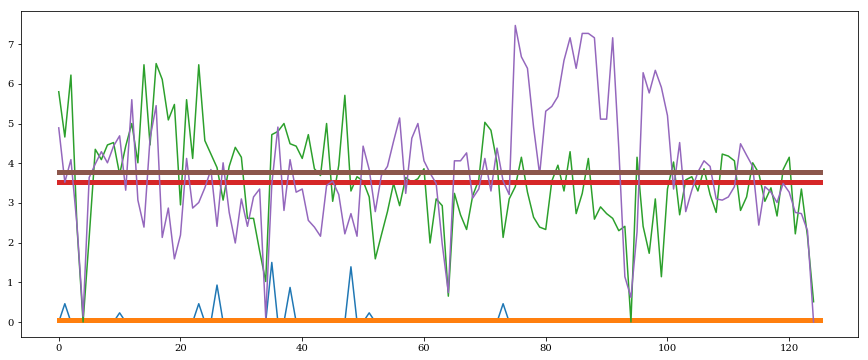

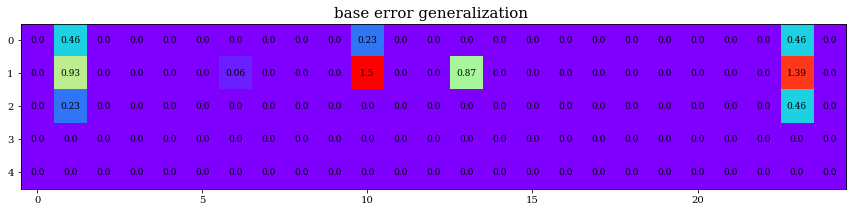

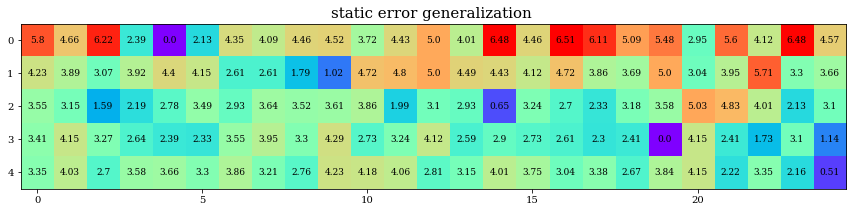

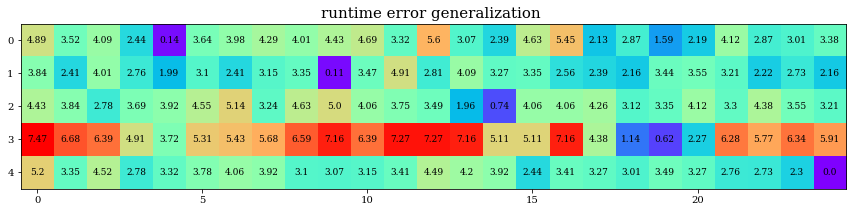

In [18]:
base_errors_3 = []
get_errors(base_results_3, base_errors_3)

static_errors_3 = []
get_errors(static_results_3, static_errors_3)

runtime_errors_3 = []
get_errors(runtime_results_3, runtime_errors_3)

plt.figure(10, figsize=(15,6))
plt.plot(base_errors_3)
mean = np.mean(base_errors_3)
plt.plot([0, len(base_errors_3)], [mean, mean], linewidth=5)
plt.plot(static_errors_3)
mean = np.mean(static_errors_3)
plt.plot([0, len(static_errors_3)], [mean, mean], linewidth=5)
plt.plot(runtime_errors_3)
mean = np.mean(runtime_errors_3)
plt.plot([0, len(runtime_errors_3)], [mean, mean], linewidth=5)
plt.show()


def get_error_matrices2(errors, error_matrix, length=N):
    for i in range(0, len(errors)):
        row = math.floor(i/length)
        col = i % length
        error_matrix[row][col] = errors[i]
            


x = math.floor(len(base_errors_3)/N)
base_error_matrix = np.empty([x,N], dtype=float)
get_error_matrices2(base_errors_3, base_error_matrix)

x = math.floor(len(static_errors_3)/N)
static_error_matrix = np.empty([x,N], dtype=float)
get_error_matrices2(static_errors_3, static_error_matrix)

x = math.floor(len(runtime_errors_3)/N)
runtime_error_matrix = np.empty([x,N], dtype=float)
get_error_matrices2(runtime_errors_3, runtime_error_matrix)


def plot_matrices2(error_matrix, mode, x=N, y=N):       
    #Display error matrix  
    fig, ax = plt.subplots(figsize=(int(N/2), int(N/2)))
    im = ax.imshow(error_matrix, cmap=colormap)
    for i in range(0,x):
        for j in range(0,y):
            text = ax.text(j, i, error_matrix[i, j], ha="center", va="center", color="black", fontsize = 9)

    ax.set_title(mode+" error generalization ", fontsize = 15)
    fig.tight_layout()
    plt.show()
    plt.savefig(mode+'_error_generalization_class_xp3.png', dpi=300)


plot_matrices2(base_error_matrix, 'base', x=5)
plot_matrices2(static_error_matrix, 'static', x=5)    
plot_matrices2(runtime_error_matrix, 'runtime', x=5) 